In [4]:
import os
import json
import pandas as pd
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import faiss

import soundfile as sf
import random
from tqdm import tqdm
import time

import sounddevice as sd
from scipy.io.wavfile import write

import noisereduce as nr
import json
import glob

import torch
import tensorflow_hub as hub
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model

import tensorflow_hub as hub
import tensorflow as tf

C:\Users\shri\anaconda3\envs\information_retrieval\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


Loading metadata and audio dataset

In [5]:
Audio_MNIST_Path = r"C:\Users\shri\Data_Science\Image_generation\audio_samples\archive\data"
metadata_path = r"C:\Users\shri\Data_Science\Image_generation\audio_samples\archive\audioMNIST_meta.txt"

In [6]:
# reading metadata as JSON

In [7]:
with open(metadata_path, "r") as f:
    metadata = json.load(f)
    

In [8]:
metadata['01']

{'accent': 'german',
 'age': 30,
 'gender': 'male',
 'native speaker': 'no',
 'origin': 'Europe, Germany, Wuerzburg',
 'recordingdate': '17-06-22-11-04-28',
 'recordingroom': 'Kino'}

* Creating a metadata dataframe which can be used to filter the audios or in the UI during the retrieval of the audios.
* Features to be included in the metadata pandas file
  *  Accent
  *  Gender
  *  Age
  *  Audio Path
  *  Digit


In [9]:
metadata_list = []
for speakers in os.listdir(Audio_MNIST_Path):
    accent = metadata[speakers]['accent']
    gender = metadata[speakers]['gender']
    age = metadata[speakers]['age']
    speaker_path = os.path.join(Audio_MNIST_Path,speakers)
    for audio_files in os.listdir(speaker_path):
        
        audio_files_path = os.path.join(speaker_path , audio_files)
        
        digit = audio_files[0]
        dictionary = {"accent": accent , "gender" : gender , "age": age , "path" : audio_files_path , "digit": digit}
        metadata_list.append(dictionary)

In [10]:
# Creating a dataframe df_meta
df_meta = pd.DataFrame(metadata_list)

In [11]:
## let's explote the audio dataset 

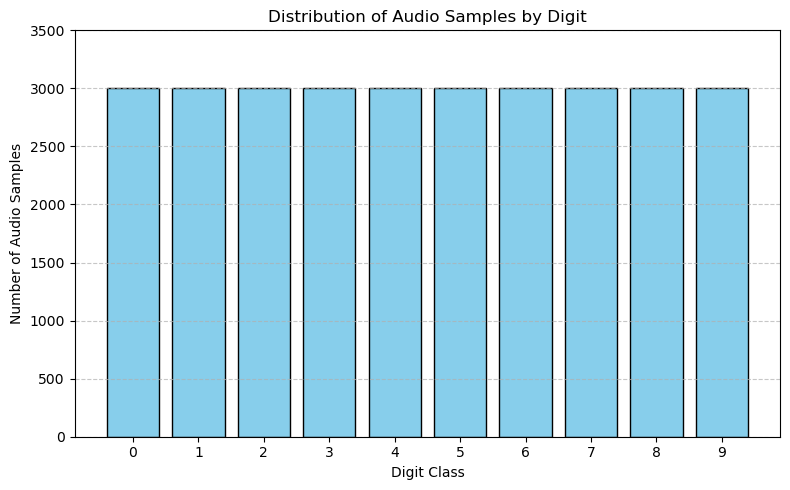

In [19]:
def plot_digit_distribution(df_meta):
    
    counts = df_meta['digit'].value_counts().sort_index()

    plt.figure(figsize=(8,5))
    plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
    plt.xlabel("Digit Class")
    plt.ylabel("Number of Audio Samples")
    plt.title("Distribution of Audio Samples by Digit")
    plt.xticks(counts.index)
    plt.ylim(0, counts.max() + 500)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_digit_distribution(df_meta)

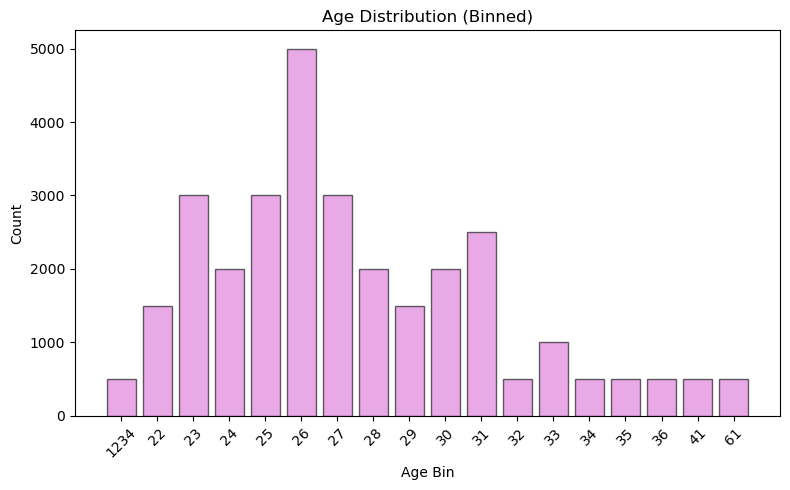

In [13]:
age_counts = df_meta["age"].astype(str).value_counts().sort_index()
plt.figure(figsize=(8, 5))
plt.bar(age_counts.index, age_counts.values, color='orchid', alpha=0.6, edgecolor='black')

plt.xlabel("Age Bin")
plt.ylabel("Count")
plt.title("Age Distribution (Binned)")

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

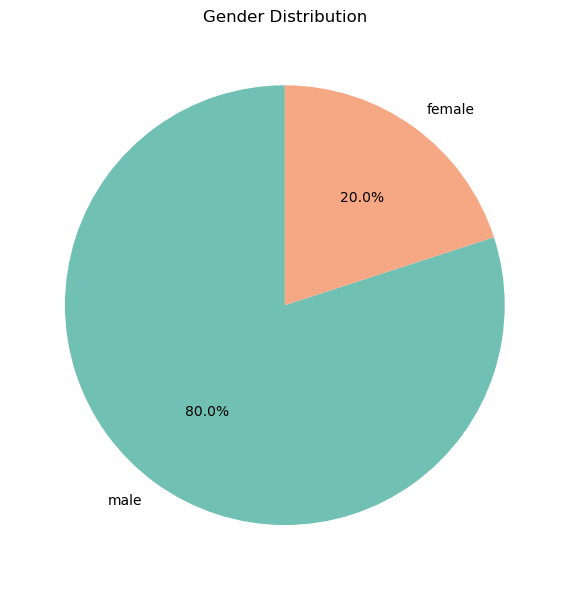

In [14]:
def plot_gender_distribution(df_meta):

    counts = df_meta["gender"].value_counts()
    
    plt.figure(figsize=(6,6))
    plt.pie(
        counts.values,
        labels=counts.index,
        autopct="%1.1f%%",
        colors=["#70c1b3", "#f6a783"],
        startangle=90
    )
    plt.title("Gender Distribution")
    plt.tight_layout()
    plt.show()

plot_gender_distribution(df_meta)

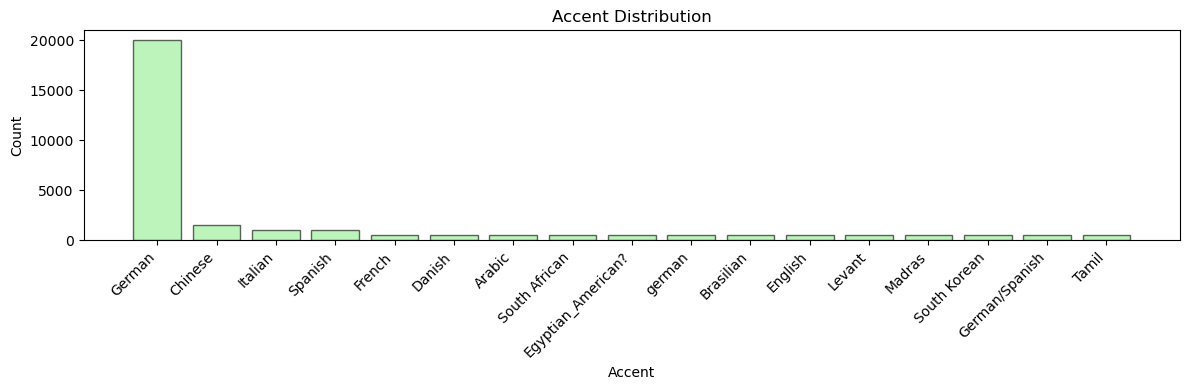

In [29]:
accent_counts = df_meta["accent"].value_counts()

plt.figure(figsize=(12, 4))
bars = plt.bar(accent_counts.index, accent_counts.values, color='lightgreen', edgecolor='black', alpha=0.6)

plt.xlabel("Accent")
plt.ylabel("Count")
plt.title("Accent Distribution")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

* The dataset contains a perfectly balanced distribution with ~3000 audio samples per digit class (0–9).
* Most samples are between ages 22–31, with a notable outlier age value of 1234 requiring cleaning. But I didn't remove that as this is not any classification or regression project.
* The dataset is imbalanced with 80% male and 20% female samples.
* The dataset is heavily imbalanced, with the vast majority of samples labeled as German accent, while all other accents have relatively few recordings. This will affect the performance when I will try to extract samples similar to my audio sample as I am Indian and have indian accent.

#### Exploratory Data Analysis

Let's analyse few other properties of the audio like "rms", "bandwidth" , "duration", "zcr" etc

In [57]:
data = []
for path in tqdm(df_meta['path']):  
    y, sr = librosa.load(path, sr=16000)
    y = y / np.max(np.abs(y))  

    duration = librosa.get_duration(y=y, sr=sr)
    rms = np.mean(librosa.feature.rms(y=y))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))

    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    # MFCC mean for clustering
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Digit
    digit = os.path.basename(path).split('_')[0] 

    data.append({
        "path": path,
        "digit": digit,
        "duration": duration,
        "rms": rms,
        "zcr": zcr,
        "centroid": centroid,
        "bandwidth": bandwidth,
        "rolloff": rolloff,
        **{f"mfcc_{i+1}": val for i, val in enumerate(mfcc_mean)}
    })

df_audio = pd.DataFrame(data)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [07:11<00:00, 69.48it/s]


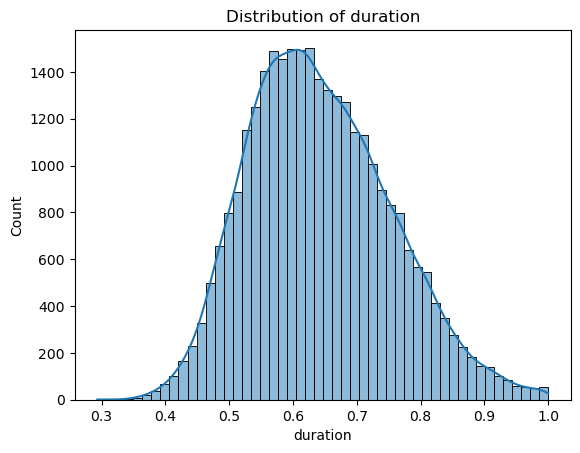

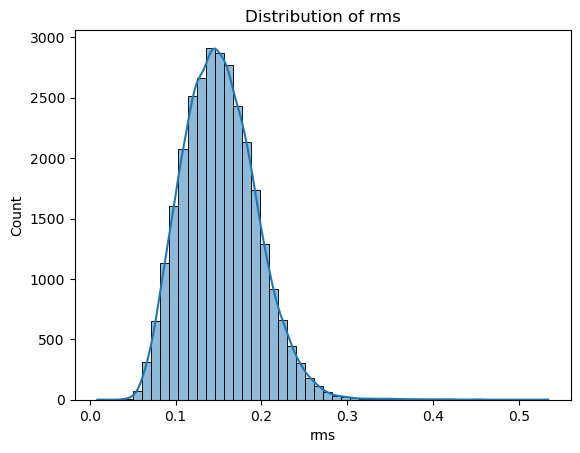

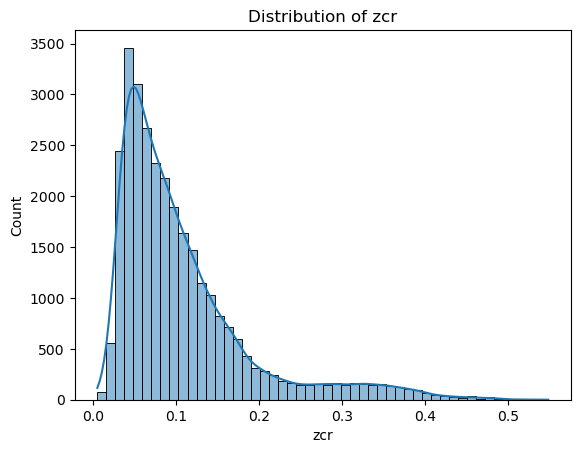

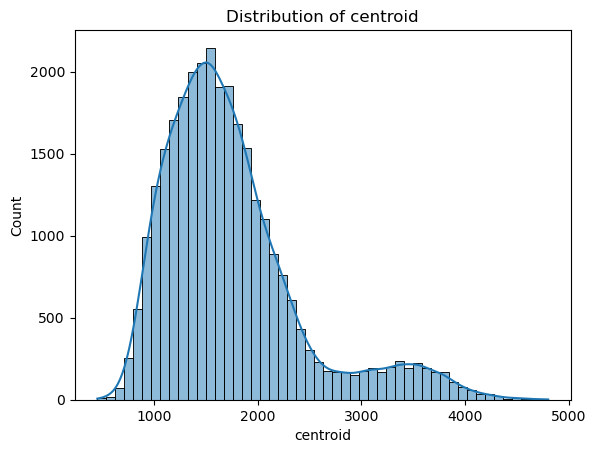

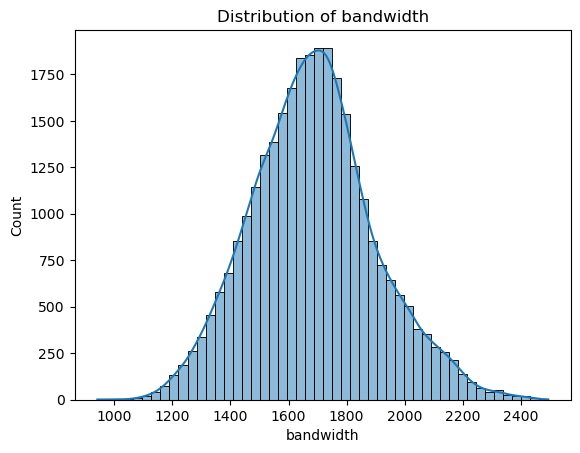

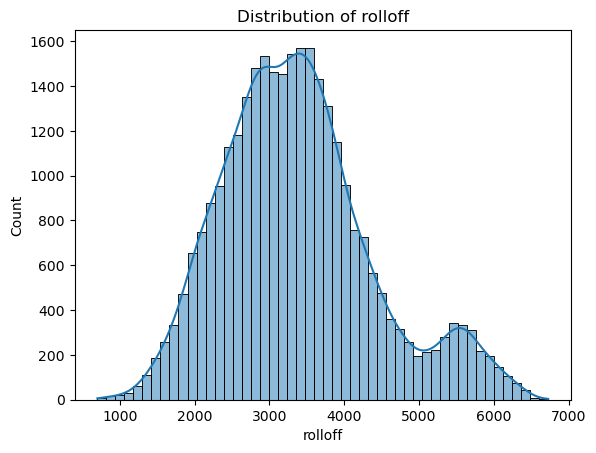

In [28]:
features = ['duration', 'rms', 'zcr', 'centroid', 'bandwidth', 'rolloff']
for feat in features:
    plt.figure()
    sns.histplot(df_audio[feat], kde=True, bins=50)
    plt.title(f"Distribution of {feat}")
    plt.show()

* Most of the audio clips last around 0.6 seconds. This suggests the recordings are short and fairly consistent in length, with only a few that are much shorter or longer than average.
* The loudness of the clips clusters nicely around a value of about 0.15.Most samples have similar volume levels, so there isn’t a big variation in how loud or soft the recordings are overall.
* Most clips have a low ZCR, with the number of higher-ZCR samples dropping off quickly. This means the majority of recordings are smoother, voiced sounds rather than noisy or sharp sounds.
*  The brightness of the audio (how high the frequencies tend to be) is mostly concentrated around 1500 Hz, but there are also some recordings with much brighter, higher-frequency content. Generally, clips sound moderately bright, though a few have more pronounced high-frequency energy.
*  Most samples have a similar frequency spread centered around 1750 Hz. This indicates the recordings contain comparable amounts of frequency variation and complexity.


Let's see the individual waveform and spectogram

In [32]:
df_meta.head()

accent gender age                                               path digit
0  german   male  30  C:\Users\shri\Data_Science\Image_generation\au...     0
1  german   male  30  C:\Users\shri\Data_Science\Image_generation\au...     0
2  german   male  30  C:\Users\shri\Data_Science\Image_generation\au...     0
3  german   male  30  C:\Users\shri\Data_Science\Image_generation\au...     0
4  german   male  30  C:\Users\shri\Data_Science\Image_generation\au...     0

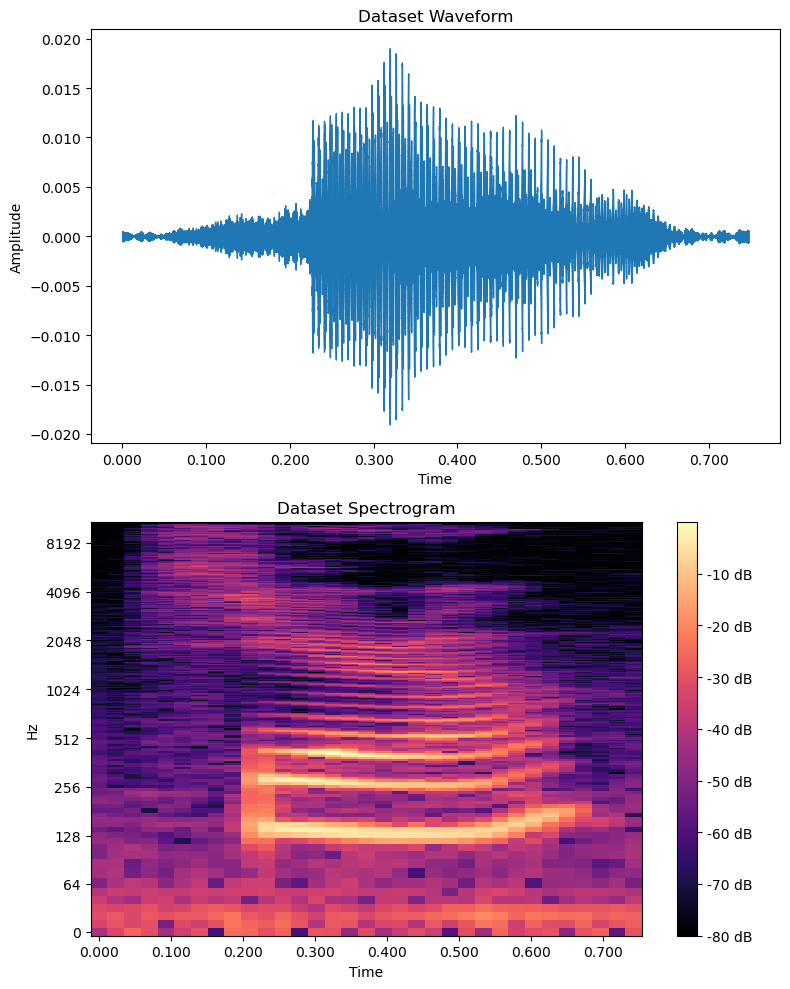

In [33]:
zero_digit_path = df_meta[df_meta['digit']=='0'].iloc[0]['path']
y, sr = librosa.load(zero_digit_path)

plt.figure(figsize=(8, 10))

# waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Dataset Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")

#spectrogram
plt.subplot(2, 1, 2)
# Compute spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Dataset Spectrogram")
plt.xlabel("Time")
plt.ylabel("Hz")

plt.tight_layout()
plt.show()


Waveforms and spectrograms representations confirmed that the dataset recordings are clean and consistently processed. Waveforms showed no evidence of clipping and clear amplitude variation corresponding to the spoken digits. Spectrograms exhibited well defined formant structures and minimal background noise.

Let's visualise the Mel Spectogramm for each digit

In [65]:
df_first_per_digit = df_meta.drop_duplicates(subset='digit', keep='first')

# Sort
df_first_per_digit = df_first_per_digit.sort_values(by='digit')

#audio paths
digit_paths = df_first_per_digit['path'].tolist()
digit_labels = df_first_per_digit['digit'].tolist()


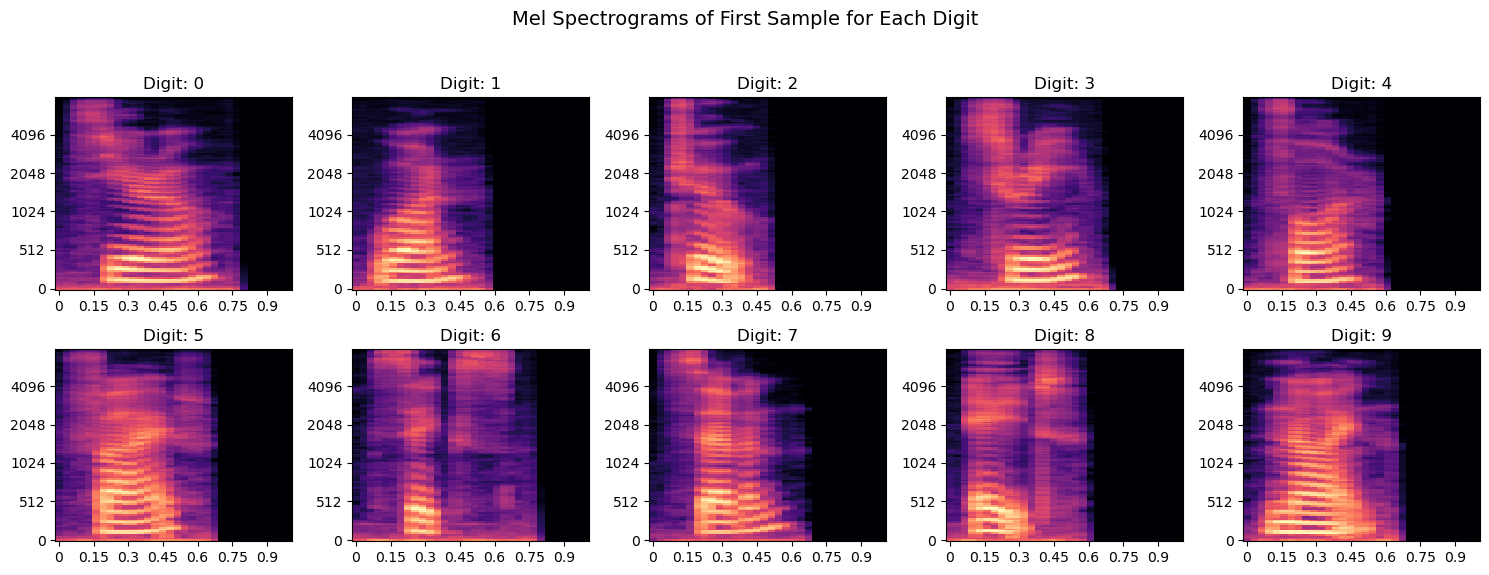

In [67]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Mel Spectrograms of First Sample for Each Digit", fontsize=14)

TARGET_LENGTH = 16000  

for i, (path, digit) in enumerate(zip(digit_paths, digit_labels)):
    y, sr = librosa.load(path, sr=16000)
    
    # Pading or trimming to 1 second
    if len(y) < TARGET_LENGTH:
        y = np.pad(y, (0, TARGET_LENGTH - len(y)), mode='constant')
    elif len(y) > TARGET_LENGTH:
        y = y[:TARGET_LENGTH]
    
    # Extractting mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    ax = axes[i // 5, i % 5]
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(f"Digit: {digit}")
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

These plots show the differences in frequency content for each digit. Some digits appear to have similar frequency patterns such as 3, 4, and 5, as well as 1 and 7. We will analyze this further in the notebook below.

After the exploratory data analysis of the audio dataset including waveform inspection, spectrogram visualization, and analysis of duration, energy, and spectral features, I observed that the audio samples are fairly clean, well segmented and free from significant noise or distortion. While there is some imbalance in accent and gender labels, the recordings themselves do not require substantial preprocessing. The dataset is ready for the next step of vectorization and feature extraction.

### Let's record few sample queries (one for each digit), this will help in the evaluation of the audio retrieval system later.

In [35]:
save_dir = "recorded_queries_clean"
os.makedirs(save_dir, exist_ok=True)

sr = 16000
duration = 4.0

for i in range(10):
    input(f"\nPress ENTER to record digit '{i}'...")
    print("Get ready...")
    time.sleep(1)
    print(f"Recording for {duration} seconds...")
    
    audio = sd.rec(int(sr * duration), samplerate=sr, channels=1)
    sd.wait()
    
    # Flatten & trim silence
    y = audio.flatten()
    y_trimmed, _ = librosa.effects.trim(y, top_db=30)

    # Normalize
    y_trimmed = y_trimmed / np.max(np.abs(y_trimmed))

    # Save as WAV
    out_path = os.path.join(save_dir, f"{i}.wav")
    write(out_path, sr, (y_trimmed * 32767).astype(np.int16))
    print(f"Saved: {out_path}")

Operations I performed while recording 
* Trim silence from the start and end.
* Normalize the volume.

In [49]:
# query_files = sorted(glob.glob("recorded_queries/*.wav"))

# # For example, extract duration and RMS energy
# query_data = []
# for f in query_files:
#     y, sr = librosa.load(f)
#     duration = librosa.get_duration(y=y, sr=sr)
#     rms = np.mean(librosa.feature.rms(y=y))
#     query_data.append({"filename": f, "duration": duration, "rms": rms})

# df_queries = pd.DataFrame(query_data)

data_querry = []

for path in tqdm(os.listdir(save_dir)):  # list of full audio paths
    path = os.path.join(save_dir,path)
    y, sr = librosa.load(path, sr=16000)
    y = y / np.max(np.abs(y))  # normalize

    # Duration
    duration = librosa.get_duration(y=y, sr=sr)

    # Energy
    rms = np.mean(librosa.feature.rms(y=y))

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))

    # Spectral Features
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    # MFCC mean (optional, for clustering)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Digit (extract from path or metadata if available)
    digit = os.path.basename(path).split('_')[0]  # adjust based on filename

    data_querry.append({
        "path": path,
        "digit": digit,
        "duration": duration,
        "rms": rms,
        "zcr": zcr,
        "centroid": centroid,
        "bandwidth": bandwidth,
        "rolloff": rolloff,
        **{f"mfcc_{i+1}": val for i, val in enumerate(mfcc_mean)}
    })

df_querry = pd.DataFrame(data_querry)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.76it/s]


In [51]:

# audio_data = []
# for f in df_meta["path"]:
#     y, sr = librosa.load(f)
#     duration = librosa.get_duration(y=y, sr=sr)
#     rms = np.mean(librosa.feature.rms(y=y))
#     audio_data.append({"filepath": f, "duration": duration, "rms": rms})

# df_audio = pd.DataFrame(audio_data)

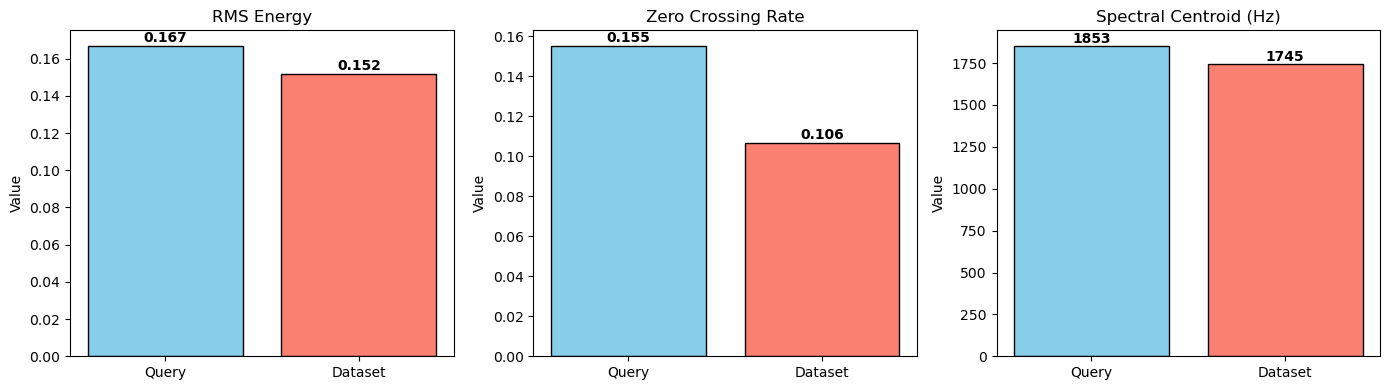

In [60]:
mean_rms_dataset = df_audio["rms"].mean()
mean_rms_queries = df_querry["rms"].mean()

mean_zcr_dataset = df_audio["zcr"].mean()
mean_zcr_queries = df_querry["zcr"].mean()

mean_centroid_dataset = df_audio["centroid"].mean()
mean_centroid_queries = df_querry["centroid"].mean()

# Set up figure
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

#  RMS Energy
axes[0].bar(["Query", "Dataset"], [mean_rms_queries, mean_rms_dataset], 
            color=["skyblue", "salmon"], edgecolor="black")
axes[0].set_title("RMS Energy")
axes[0].set_ylabel("Value")
for i, v in enumerate([mean_rms_queries, mean_rms_dataset]):
    axes[0].text(i, v + 0.002, f"{v:.3f}", ha="center", fontweight="bold")

#  Zero Crossing Rate
axes[1].bar(["Query", "Dataset"], [mean_zcr_queries, mean_zcr_dataset], 
            color=["skyblue", "salmon"], edgecolor="black")
axes[1].set_title("Zero Crossing Rate")
axes[1].set_ylabel("Value")
for i, v in enumerate([mean_zcr_queries, mean_zcr_dataset]):
    axes[1].text(i, v + 0.002, f"{v:.3f}", ha="center", fontweight="bold")

#  Spectral Centroid
axes[2].bar(["Query", "Dataset"], [mean_centroid_queries, mean_centroid_dataset], 
            color=["skyblue", "salmon"], edgecolor="black")
axes[2].set_title("Spectral Centroid (Hz)")
axes[2].set_ylabel("Value")
for i, v in enumerate([mean_centroid_queries, mean_centroid_dataset]):
    axes[2].text(i, v + 20, f"{v:.0f}", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

This comparison shows that the recorded queries have slightly higher RMS energy (0.167 vs. 0.152), indicating they are marginally louder on average. The zero crossing rate is notably higher in the queries (0.155) compared to the dataset (0.106), suggesting the queries may have more high-frequency content or noisier characteristics. Finally, the spectral centroid is also a bit higher for the queries (1853 Hz vs. 1745 Hz), reflecting a slightly brighter overall sound. Overall, while the differences are less extreme

## Vectorisation, Indexing and Evaluation Part


#### At first I converting audio signals to 13D vectors.

In [11]:
metadata_list = []
durations = []
mfcc_features_list =[]

for speakers in os.listdir(Audio_MNIST_Path):
    accent = metadata[speakers]['accent']
    gender = metadata[speakers]['gender']
    age = metadata[speakers]['age']
    speaker_path = os.path.join(Audio_MNIST_Path,speakers)
    for audio_files in os.listdir(speaker_path):
        
        audio_files_path = os.path.join(speaker_path , audio_files)
        y, sr = librosa.load(audio_files_path, sr=16000)
        
        if len(y) < 16000:
            y = np.pad(y, (0, 16000 - len(y)), mode='constant')
        else:
            y = y[:16000]

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_features_list.append(mfcc_mean)

        
        duration = len(y) / sr  # in seconds
        durations.append( duration)
        
        digit = audio_files[0]
        dictionary = {"accent": accent , "gender" : gender , "age": age , "path" : audio_files_path , "digit": digit}
        metadata_list.append(dictionary)

Before converting the samples to MFCC features I am padding them with zeros if they are shorter than 1 sec.

Let's do dimentionality reduction of 13D vectors -> 2D vectors using tSNE for visualisation

In [61]:
# Converting MFCC list to matrix
X = np.array(mfcc_features_list)  

# Reducing to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X)


In [58]:
## Saving metadata, 13D vectors and 2d tSNE

In [62]:
df_meta.to_csv("audio_metadata.csv", index=False)
np.save("mfcc_features.npy", X)       # original high-dim MFCC
np.save("tsne_2d.npy", X_2d)          # t-SNE 2D


In [68]:
# # load later
# df_meta = pd.read_csv("audio_metadata.csv")
# X = np.load("mfcc_features.npy")
# X_2d = np.load("tsne_2d.npy")


In [63]:
df_tsne = pd.DataFrame()

df_tsne['tsne-1'] = X_2d[:, 0]
df_tsne['tsne-2'] = X_2d[:, 1]
df_tsne['digit'] = df_meta['digit']

In [59]:
## scatter plot of 2D Vecotr

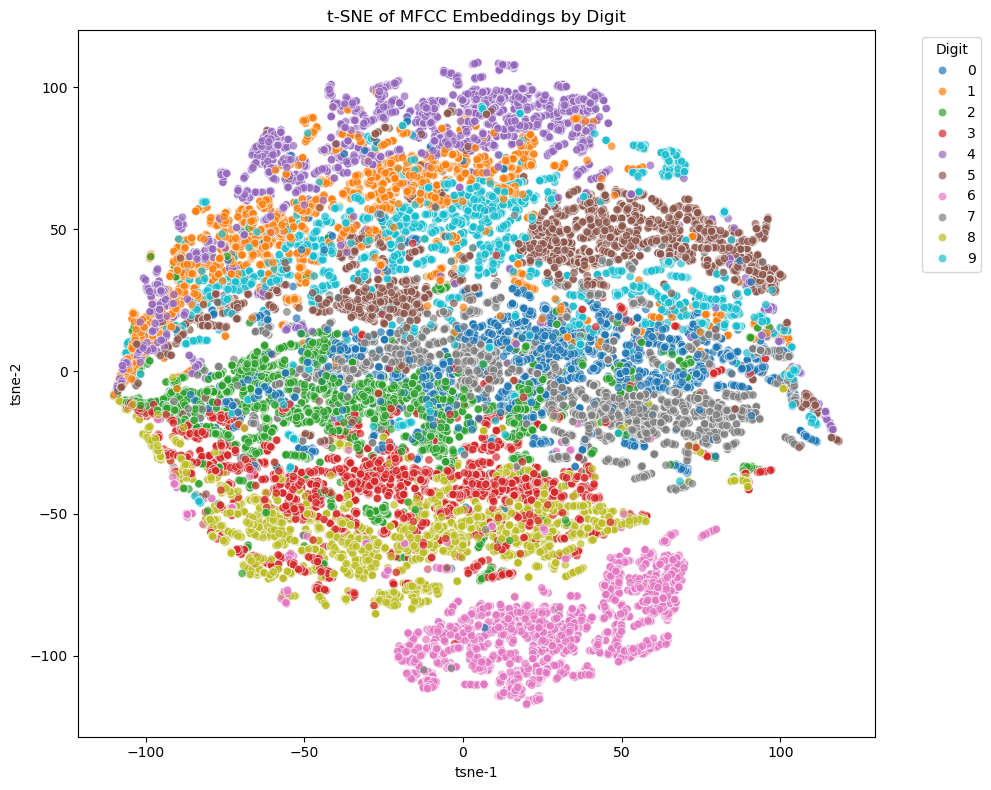

In [64]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="digit",
    palette=sns.color_palette("tab10", 10),
    data=df_tsne,
    alpha=0.7
)
plt.title("t-SNE of MFCC Embeddings by Digit")
plt.legend(title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


From the 2D scatter plot We can observe that many digits form partially distinct clusters, indicating that MFCC features capture meaningful differences in characteristics between digits. But there is also some overlap, suggesting that certain digits share similar frequency patterns, which could pose challenges for retrieval models.

#### Creating Index for the audio retrieval using faiss

Let's created a FAISS index for fast similarity search among audio samples. Initialize a flat index using L2 (Euclidean) distance as the similarity metric.

In [76]:
d = X.shape[1]  # dimensionality = 13
index = faiss.IndexFlatL2(d)  # L2 (Euclidean) distance


index.add(X)


In [77]:
## saving for later use
faiss.write_index(index, "mfcc_index.faiss")


Let's take a querry vector form the collection of audio vectors itself and analyse if its working good

In [94]:
query_vector = X[16600]  
D, I = index.search(query_vector.reshape(1, -1), k=10)  # D = distances, I = indices

In [95]:
df_meta.iloc[I[0]]


accent gender age  \
16600     German   male  25   
16608     German   male  25   
16605     German   male  25   
15118     German   male  26   
3535      German   male  41   
15149     German   male  26   
11611    Chinese   male  26   
12135  Brasilian   male  22   
12132  Brasilian   male  22   
15100     German   male  26   

                                                    path digit  
16600  C:\Users\shri\Data_Science\Image_generation\au...     2  
16608  C:\Users\shri\Data_Science\Image_generation\au...     2  
16605  C:\Users\shri\Data_Science\Image_generation\au...     2  
15118  C:\Users\shri\Data_Science\Image_generation\au...     2  
3535   C:\Users\shri\Data_Science\Image_generation\au...     0  
15149  C:\Users\shri\Data_Science\Image_generation\au...     2  
11611  C:\Users\shri\Data_Science\Image_generation\au...     2  
12135  C:\Users\shri\Data_Science\Image_generation\au...     2  
12132  C:\Users\shri\Data_Science\Image_generation\au...     2  
15100  C:\Users\shri\Data_Science\Image_generation\au...     2

We can see that all the extracted digits are 2 excenpt one that is 0 (first row is the querry itself).

In [61]:
#  Let's try cosine similarity for indexing and extraction

In [138]:

faiss.normalize_L2(X)  
index_cosine = faiss.IndexFlatIP(d)  

index_cosine.add(X) 


In [70]:
# faiss.write_index(index_cosine, "mfcc_cosine_index.faiss")
index_cosine = faiss.read_index("mfcc_cosine_index.faiss")

In [292]:
query_vector = X[6055] 
D, I = index_cosine.search(query_vector.reshape(1, -1), k=10)  

In [293]:
df_meta.iloc[I[0][1:]]["digit"].tolist()

['1', '1', '1', '1', '1', '1', '1', '1', '1']

When the querry vector is from audio collection itself cosine is also working good

Let's write some functions for evaluation of this retrieval system

In [14]:
def precision_at_k(y_true, y_pred, k=10):
    y_pred = [str(p) for p in y_pred]
    y_true = [str(y_true[0])]
    hits = sum(1 for pred in y_pred[:k] if pred in y_true)
    return hits / k

def average_precision(y_true, y_pred, k=10):
    hits = 0
    score = 0.0
    y_pred = [str(p) for p in y_pred]
    y_true = [str(y_true[0])]
    for i, pred in enumerate(y_pred[:k]):
        if pred in y_true:
            hits += 1
            score += hits / (i + 1)
    if hits == 0:
        return 0.0
    return score / hits

def reciprocal_rank(y_true, y_pred):
    y_pred = [str(p) for p in y_pred]
    y_true = [str(y_true[0])]
    for i, pred in enumerate(y_pred):
        if pred in y_true:
            return 1.0 / (i + 1)
    return 0.0


In [63]:
###Let's choose 10 random audio samples as querry form the collection and evaluate the performance.

In [182]:
random_numbers = random.sample(range(30000), 10)
print(random_numbers)

[24376, 2092, 25549, 7209, 9012, 1525, 16475, 13734, 2769, 6020]


In [91]:
k = 10
precisions = []
average_precisions = []
mrrs = []

for i in tqdm(range(X.shape[0])):
    # print(i)
    query_vector = X[i].reshape(1, -1)
    true_label = df_meta.iloc[i]["digit"]

    query_vector = query_vector.reshape(1, -1)
    faiss.normalize_L2(query_vector)
    
    # Get top-k results (excluding self)
    D, I = index_cosine.search(query_vector, k + 1)
    result_indices = I[0][1:]  # skip self-match

    result_labels = df_meta.iloc[result_indices]["digit"].tolist()
    
    # Compute metrics
    y_true = [true_label]  # relevant = same digit
    y_pred = result_labels
    # print(y_true)
    # print(y_pred)
    precisions.append(precision_at_k(y_true, y_pred, k))
    average_precisions.append(average_precision(y_true, y_pred, k))
    mrrs.append(reciprocal_rank([true_label], result_labels))


100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:02<00:00, 477.55it/s]


In [92]:
print(f"Mean Precision@{k}: {np.mean(precisions):.4f}")
print(f"Mean Average Precision (MAP): {np.mean(average_precisions):.4f}")
print(f"Mean Reciprocal Rank (MRR): {np.mean(mrrs):.4f}")

Mean Precision@10: 0.9027
Mean Average Precision (MAP): 0.9445
Mean Reciprocal Rank (MRR): 0.9690


The retrieval evaluation shows that the system achieves high accuracy with a Mean Precision@10 of 90.27%, Mean Average Precision (MAP) of 94.45%, and Mean Reciprocal Rank (MRR) of 96.90%. This indicate that the MFCC embeddings combined with cosine similarity are effective at retrieving audio samples of the same digit with good precision.

Let's try to record an audio and extract the similar audio samples from the collection

In [274]:
sr = 16000
duration = 2  # seconds

# Step 1: Record full 2 seconds
print("🎙 Recording for 2 seconds...")
recording = sd.rec(int(sr * duration), samplerate=sr, channels=1)
sd.wait()
recording = recording.flatten()
print(" Recording finished!")

# Save original for reference
write("query_raw.wav", sr, (recording * 32767).astype(np.int16))

#  Simple background noise reduction using pre-emphasis filter
def pre_emphasize(y, coeff=0.97):
    return np.append(y[0], y[1:] - coeff * y[:-1])

y_clean = pre_emphasize(recording)

#  Extract MFCC over full 4 seconds
mfcc = librosa.feature.mfcc(y=y_clean, sr=sr, n_mfcc=13)

mfcc_mean = np.mean(mfcc, axis=1).astype('float32')  # shape: (13,)
print("MFCC mean vector:", mfcc_mean)




🎙 Recording for 4 seconds...
✅ Recording finished!
MFCC mean vector: [-8.3140186e+02 -3.8935711e+01  5.0881014e+00  4.3534608e+00
  1.3641837e+00  1.3211733e+00  2.4051544e-01  3.0060318e-01
 -2.6390240e+00 -2.6118784e+00  2.5016686e-01 -2.0776289e+00
 -2.9242344e+00]


In [275]:
#  Normalize if using cosine similarity
faiss.normalize_L2(mfcc_mean.reshape(1, -1))

#  FAISS Query
D, I = index_cosine.search(mfcc_mean.reshape(1, -1), k=10)

# Display Results
print("\n Top-10 Most Similar Results:")
print(df_meta.iloc[I[0]][["digit", "gender", "age", "accent", "path"]])


🔍 Top-10 Most Similar Results:
      digit  gender age        accent  \
23314     6  female  23        Danish   
29341     6  female  31        German   
29340     6  female  31        German   
2812      6    male  25        German   
21844     6    male  61        German   
18825     6    male  32       Spanish   
29344     6  female  31        German   
4346      6    male  35  South Korean   
3806      6    male  41        German   
25814     6  female  34        French   

                                                    path  
23314  C:\Users\shri\Data_Science\Image_generation\au...  
29341  C:\Users\shri\Data_Science\Image_generation\au...  
29340  C:\Users\shri\Data_Science\Image_generation\au...  
2812   C:\Users\shri\Data_Science\Image_generation\au...  
21844  C:\Users\shri\Data_Science\Image_generation\au...  
18825  C:\Users\shri\Data_Science\Image_generation\au...  
29344  C:\Users\shri\Data_Science\Image_generation\au...  
4346   C:\Users\shri\Data_Science\Image_gene

The recorded querry was 1 but all the extracted audio samples belongs to 6 digit.

Let's try below preprocessing techniques to the recorded querry audio and then try to extract the similar audio samples

##### 1. Pre- Emphasis
##### 2. Denoise
##### 3. Trim- Silence
##### 4. Normalise
##### 5. Pad or Clip to 1 sec

In [308]:
def record_audio(sr=16000, duration=4):
    print(" Recording for 4 seconds...")
    audio = sd.rec(int(sr * duration), samplerate=sr, channels=1)
    sd.wait()
    return audio.flatten()

def preprocess_audio(y, sr=16000):
    print(" Preprocessing...")

    y_pre = np.append(y[0], y[1:] - 0.97 * y[:-1])

    # Denoise
    y_denoised = nr.reduce_noise(y=y_pre, sr=sr)

    # Trim silence
    y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=30)

    # Normalize
    if np.max(np.abs(y_trimmed)) > 0:
        y_trimmed = y_trimmed / np.max(np.abs(y_trimmed))

    # Pad or clip to 1 sec
    target_len = sr
    if len(y_trimmed) < target_len:
        y_trimmed = np.pad(y_trimmed, (0, target_len - len(y_trimmed)))
    else:
        y_trimmed = y_trimmed[:target_len]

    return y_trimmed



🎙 Recording for 4 seconds...
🔊 Playing raw audio...
🔧 Preprocessing...
🔊 Playing cleaned audio...
✅ Saved: recorded_raw.wav
✅ Saved: recorded_clean.wav


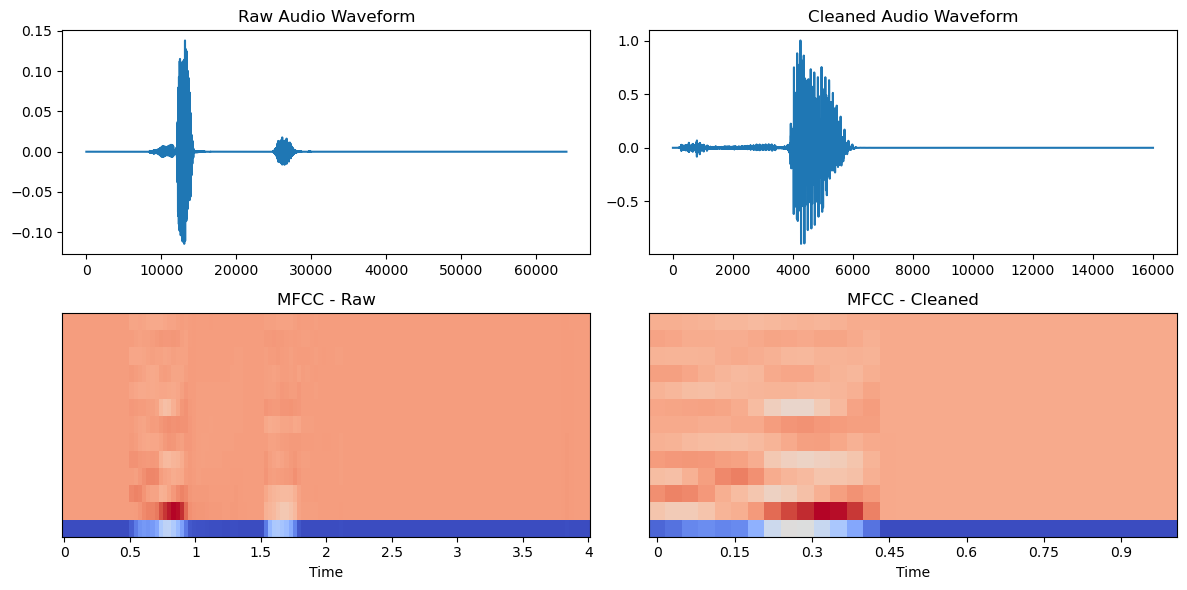

In [374]:
# Record raw query
sr = 16000
y_raw = record_audio(sr)

#  Play raw
print(" Playing raw audio...")
sd.play(y_raw, sr)
sd.wait()

#  Preprocess
y_clean = preprocess_audio(y_raw, sr)

#  Play cleaned
print(" Playing cleaned audio...")
sd.play(y_clean, sr)
sd.wait()


# Scale audio to int16 before saving
def save_audio(filename, y, sr):
    y_int16 = (y * 32767).astype(np.int16)
    write(filename, sr, y_int16)
    print(f" Saved: {filename}")

# Save raw audio
save_audio("recorded_raw.wav", y_raw, sr)

# Save cleaned audio
save_audio("recorded_clean.wav", y_clean, sr)


# Plot waveform + MFCCs
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Waveforms
axs[0, 0].plot(y_raw)
axs[0, 0].set_title("Raw Audio Waveform")

axs[0, 1].plot(y_clean)
axs[0, 1].set_title("Cleaned Audio Waveform")

# MFCCs
mfcc_raw = librosa.feature.mfcc(y=y_raw, sr=sr, n_mfcc=13)
mfcc_clean = librosa.feature.mfcc(y=y_clean, sr=sr, n_mfcc=13)

librosa.display.specshow(mfcc_raw, sr=sr, ax=axs[1, 0], x_axis='time')
axs[1, 0].set_title("MFCC - Raw")

librosa.display.specshow(mfcc_clean, sr=sr, ax=axs[1, 1], x_axis='time')
axs[1, 1].set_title("MFCC - Cleaned")

plt.tight_layout()
plt.show()

From the above plot I have showed that I have removed the high frequencey noise from the recording and then vectorised the audio

In [375]:
mfcc_mean = np.mean(mfcc_clean, axis=1).astype('float32')  # shape: (13,)

In [377]:
# Step 5: FAISS Query
D, I = index_cosine.search(mfcc_mean.reshape(1, -1), k=10)

# Step 6: Display Results
print("\n Top-10 Most Similar Results:")
print(df_meta.iloc[I[0]][["digit", "gender", "age", "accent", "path"]])


🔍 Top-10 Most Similar Results:
      digit  gender age          accent  \
28746     4  female  29          German   
28737     4  female  29          German   
28706     4  female  29          German   
28735     4  female  29          German   
28718     4  female  29          German   
3244      4    male  27  German/Spanish   
29230     4  female  31          German   
28743     4  female  29          German   
29238     4  female  31          German   
25716     4  female  34          French   

                                                    path  
28746  C:\Users\shri\Data_Science\Image_generation\au...  
28737  C:\Users\shri\Data_Science\Image_generation\au...  
28706  C:\Users\shri\Data_Science\Image_generation\au...  
28735  C:\Users\shri\Data_Science\Image_generation\au...  
28718  C:\Users\shri\Data_Science\Image_generation\au...  
3244   C:\Users\shri\Data_Science\Image_generation\au...  
29230  C:\Users\shri\Data_Science\Image_generation\au...  
28743  C:\Users\shri\D

Still the spoken word was 0 and the extracted samples belong to class 4.

Let's extract the audio features from the whole audio collection and plotting the same features of clean querry audio to see what are the differences between the colelction features and querry feature 

In [383]:
def extract_features(y, sr=16000):
    return {
        "rms": np.mean(librosa.feature.rms(y=y)),
        "zcr": np.mean(librosa.feature.zero_crossing_rate(y)),
        "centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        "duration": librosa.get_duration(y=y, sr=sr),
        "mfcc_mean": np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    }


In [384]:
rms_list, zcr_list, centroid_list, duration_list = [], [], [], []

for path in tqdm(df_meta["path"].tolist()):
    try:
        y, _ = librosa.load(path, sr=16000)
        y = librosa.effects.trim(y, top_db=30)[0]
        y = y / np.max(np.abs(y))
        feats = extract_features(y)

        rms_list.append(feats["rms"])
        zcr_list.append(feats["zcr"])
        centroid_list.append(feats["centroid"])
        duration_list.append(feats["duration"])
    except:
        continue  # skip corrupted files

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [17:44<00:00, 28.18it/s]


In [385]:
y_query, _ = librosa.load("recorded_clean.wav", sr=16000)
y_query = librosa.effects.trim(y_query, top_db=30)[0]
y_query = y_query / np.max(np.abs(y_query))
query_feats = extract_features(y_query)

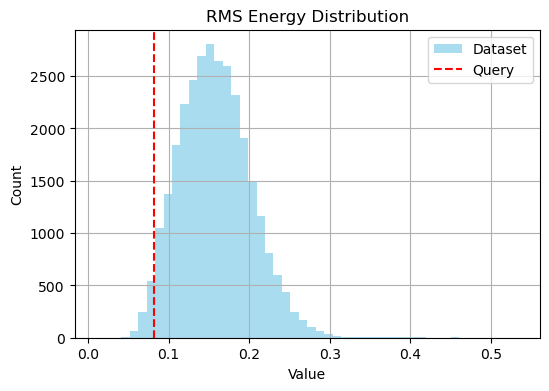

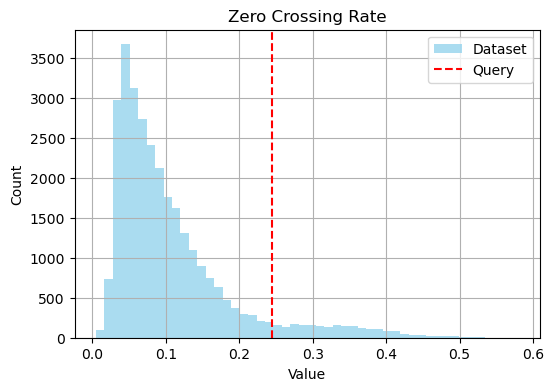

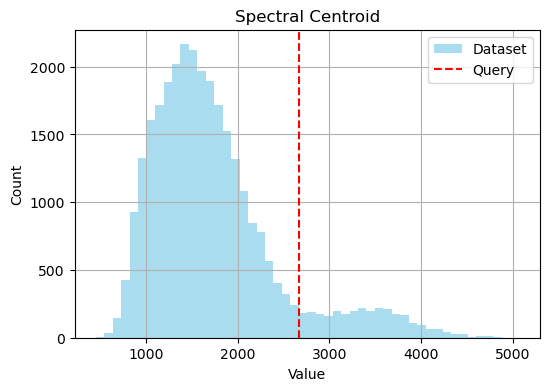

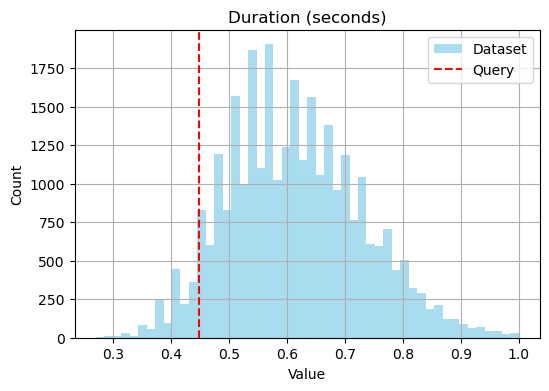

In [386]:
def plot_feature_distribution(data_list, query_value, title, color="skyblue"):
    plt.figure(figsize=(6, 4))
    plt.hist(data_list, bins=50, alpha=0.7, color=color, label="Dataset")
    plt.axvline(query_value, color='red', linestyle='--', label='Query')
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_feature_distribution(rms_list, query_feats["rms"], "RMS Energy Distribution")
plot_feature_distribution(zcr_list, query_feats["zcr"], "Zero Crossing Rate")
plot_feature_distribution(centroid_list, query_feats["centroid"], "Spectral Centroid")
plot_feature_distribution(duration_list, query_feats["duration"], "Duration (seconds)")


Despite applying silence trimming and normalization, the recorded query exhibits higher zero crossing rate and spectral centroid compared to most dataset samples. This indicates that factors such as accent, microphone characteristics, or pronunciation are introducing more high-frequency content and signal variability. These differences can explain the retrieval system's difficulty in matching my recordings to the dataset,

In [93]:
# Parameters
query_dir = "recorded_queries_clean"
sr = 16000
k = 10

# Store evaluation
true_labels = []
precisions = []
average_precisions = []
reciprocal_ranks = []

def extract_mfcc_mean(y, sr=16000, n_mfcc=13):
    y = y / np.max(np.abs(y))
    y, _ = librosa.effects.trim(y, top_db=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1).astype('float32')


for filename in sorted(os.listdir(query_dir)):
    digit = str(os.path.splitext(filename)[0])
    true_labels.append(digit)

    path = os.path.join(query_dir, filename)
    y, _ = librosa.load(path, sr=sr)

    mfcc_mean = extract_mfcc_mean(y, sr)
    faiss.normalize_L2(mfcc_mean.reshape(1, -1))  # if using cosine index

    D, I = index_cosine.search(mfcc_mean.reshape(1, -1), k)

    # Retrieved digit labels
    retrieved_digits = list(map(str, df_meta.iloc[I[0]]["digit"].tolist()))
    # true_digit = str(df_meta.iloc[idx]["digit"])  # Convert to string
    # result_digits = list(map(str, df_meta.iloc[I[0]]["digit"].tolist()))  # Also strings

    # --- Evaluate ---
    precisions.append(precision_at_k(digit, retrieved_digits, k))
    average_precisions.append(average_precision(digit, retrieved_digits))
    reciprocal_ranks.append(reciprocal_rank(digit, retrieved_digits))

    print(f"\n🎤 Query Digit: {digit}")
    print(f"🔍 Top-{k} Retrieved: {retrieved_digits}")

# ---- Summary ----
print("\nEvaluation Summary:")
print(f"Mean Precision@{k}: {np.mean(precisions):.4f}")
print(f"Mean Average Precision (MAP): {np.mean(average_precisions):.4f}")
print(f"Mean Reciprocal Rank (MRR): {np.mean(reciprocal_ranks):.4f}")


🎤 Query Digit: 0
🔍 Top-10 Retrieved: ['4', '4', '4', '4', '4', '4', '4', '0', '4', '4']

🎤 Query Digit: 1
🔍 Top-10 Retrieved: ['4', '4', '4', '4', '4', '4', '5', '4', '4', '4']

🎤 Query Digit: 2
🔍 Top-10 Retrieved: ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4']

🎤 Query Digit: 3
🔍 Top-10 Retrieved: ['9', '9', '9', '4', '0', '0', '9', '9', '4', '9']

🎤 Query Digit: 4
🔍 Top-10 Retrieved: ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4']

🎤 Query Digit: 5
🔍 Top-10 Retrieved: ['0', '9', '9', '9', '9', '0', '9', '0', '9', '0']

🎤 Query Digit: 6
🔍 Top-10 Retrieved: ['6', '6', '6', '6', '6', '6', '6', '6', '6', '6']

🎤 Query Digit: 7
🔍 Top-10 Retrieved: ['4', '4', '4', '4', '4', '4', '9', '4', '4', '4']

🎤 Query Digit: 8
🔍 Top-10 Retrieved: ['9', '9', '4', '9', '9', '9', '4', '0', '9', '9']

🎤 Query Digit: 9
🔍 Top-10 Retrieved: ['9', '9', '9', '9', '9', '9', '9', '9', '9', '9']

📊 Evaluation Summary:
Mean Precision@10: 0.3100
Mean Average Precision (MAP): 0.3125
Mean Reciprocal Rank (MR

Now we have valid results suggesting that the 13 dimentional MFCC featurisation does retrieve the correlated results when the querry is from the 
same collection but struggles badly when the querry is in users voice. Now I want to test if the increase in the dimentionality of MFCC improves 
these retrievals. If not we will try another featurisation technique

In [387]:
# Let's try 30 dimentional MFCC vector

In [411]:
mfcc_features_list_30 =[]

for speakers in os.listdir(Audio_MNIST_Path):
    # accent = metadata[speakers]['accent']
    # gender = metadata[speakers]['gender']
    # age = metadata[speakers]['age']
    speaker_path = os.path.join(Audio_MNIST_Path,speakers)
    for audio_files in os.listdir(speaker_path):
        
        audio_files_path = os.path.join(speaker_path , audio_files)
        y, sr = librosa.load(audio_files_path, sr=16000)
        
        if len(y) < 16000:
            y = np.pad(y, (0, 16000 - len(y)), mode='constant')
        else:
            y = y[:16000]

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=30)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_features_list_30.append(mfcc_mean)

        
        # duration = len(y) / sr  # in seconds
        # durations.append( duration)
        
        # digit = audio_files[0]
        # dictionary = {"accent": accent , "gender" : gender , "age": age , "path" : audio_files_path , "digit": digit}
        # metadata_list.append(dictionary)

In [94]:
# Convert MFCC list to matrix
X_30 = np.array(mfcc_features_list_30)  # Shape: (n_samples, 30)
X_30.shape

In [96]:
X_30 = np.load("mfcc_features_30.npy")

In [38]:

# Reduce to 2D
tsne_2 = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d_30 = tsne_2.fit_transform(X_30)


In [414]:
np.save("mfcc_features_30.npy", X_30)       # original high-dim MFCC
np.save("tsne_2d_30.npy", X_2d_30)          # optional: low-dim t-SNE result


In [39]:
df_tsne_30 = pd.DataFrame()

df_tsne_30['tsne-1'] = X_2d_30[:, 0]
df_tsne_30['tsne-2'] = X_2d_30[:, 1]
df_tsne_30['digit'] = df_meta['digit']

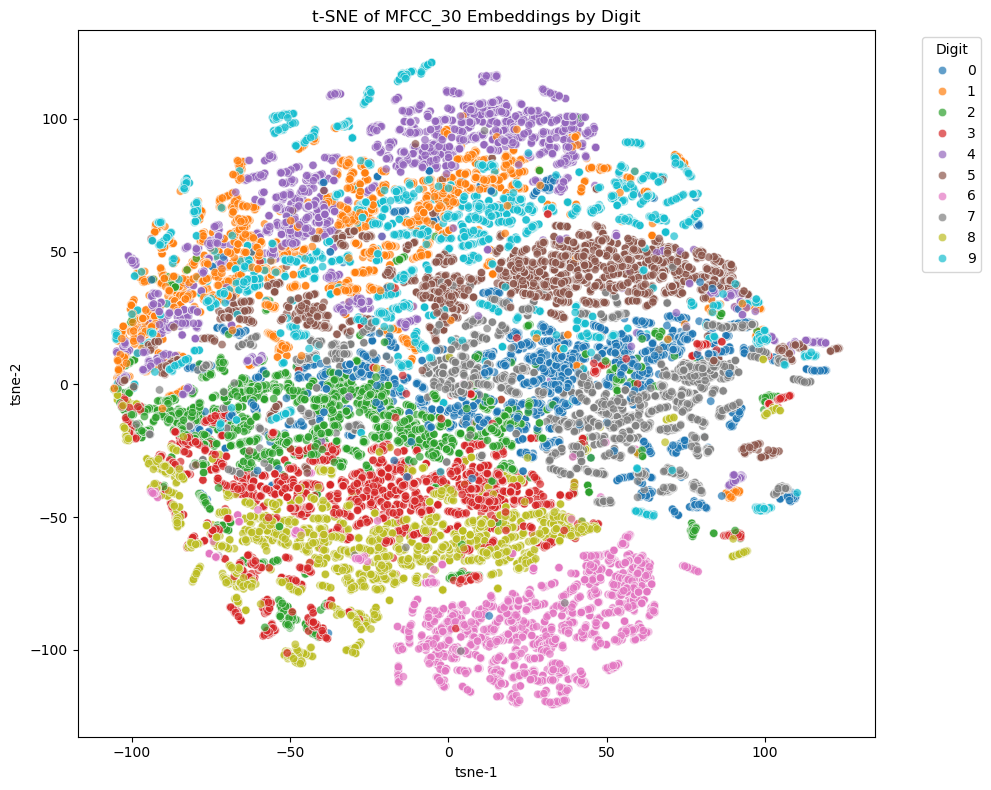

In [40]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="digit",
    palette=sns.color_palette("tab10", 10),
    data=df_tsne_30,
    alpha=0.7
)
plt.title("t-SNE of MFCC_30 Embeddings by Digit")
plt.legend(title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


From the above t-SNE of both 13D and 30D we can see that in the 13 dimentionality reduction the classes are not that well segregated but seems better grouped than 30 dimentional MFCC featurisation.

In [95]:
## Creating index for the 30D MFCC embedding

In [417]:
d = 30  # dimension of MFCC vector
index = faiss.IndexFlatIP(d)  
faiss.normalize_L2(X_30)

index.add(X_30)
faiss.write_index(index, "mfcc_30d_index.faiss")


In [97]:
## Loading
index = faiss.read_index("mfcc_30d_index.faiss")

In [99]:
k = 10
precisions = []
average_precisions = []
mrrs = []

for i in tqdm(range(X_30.shape[0])):
    # print(i)
    query_vector = X_30[i].reshape(1, -1)
    true_label = df_meta.iloc[i]["digit"]
    
    # Get top-k results (excluding self)
    D, I = index.search(query_vector, k + 1)
    result_indices = I[0][1:]  # skip self-match

    result_labels = df_meta.iloc[result_indices]["digit"].tolist()
    
    # Compute metrics
    y_true = [true_label]  # relevant = same digit
    y_pred = result_labels
    # print(y_true)
    # print(y_pred)
    precisions.append(precision_at_k(y_true, y_pred, k))
    average_precisions.append(average_precision(y_true, y_pred, k))
    mrrs.append(reciprocal_rank([true_label], result_labels))


100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:48<00:00, 276.30it/s]


In [100]:
print(f"Mean Precision@{k}: {np.mean(precisions):.4f}")
print(f"Mean Average Precision (MAP): {np.mean(average_precisions):.4f}")
print(f"Mean Reciprocal Rank (MRR): {np.mean(mrrs):.4f}")

Mean Precision@10: 0.9559
Mean Average Precision (MAP): 0.9797
Mean Reciprocal Rank (MRR): 0.9916


In [102]:
# Parameters
query_dir = "recorded_queries_clean"
sr = 16000
k = 10

# Store evaluation
true_labels = []
precisions = []
average_precisions = []
reciprocal_ranks = []

def extract_mfcc_mean(y, sr=16000, n_mfcc=30):
    y = y / np.max(np.abs(y))
    y, _ = librosa.effects.trim(y, top_db=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1).astype('float32')

# def precision_at_k(y_true, y_pred, k):
#     return sum([1 if p == y_true else 0 for p in y_pred[:k]]) / k

# def average_precision(y_true, y_pred):
#     score = 0.0
#     hit = 0
#     for i, p in enumerate(y_pred):
#         if p == y_true:
#             hit += 1
#             score += hit / (i + 1)
#     return score / 1  # only one relevant in this task

# def reciprocal_rank(y_true, y_pred):
#     for i, p in enumerate(y_pred):
#         if p == y_true:
#             return 1 / (i + 1)
#     return 0

# ---- Retrieval and Evaluation ----
for filename in sorted(os.listdir(query_dir)):
    digit = str(os.path.splitext(filename)[0])
    true_labels.append(digit)

    path = os.path.join(query_dir, filename)
    y, _ = librosa.load(path, sr=sr)

    mfcc_mean = extract_mfcc_mean(y, sr)
    faiss.normalize_L2(mfcc_mean.reshape(1, -1))  

    D, I = index.search(mfcc_mean.reshape(1, -1), k)

    # Retrieved digit labels
    retrieved_digits = list(map(str, df_meta.iloc[I[0]]["digit"].tolist()))
    # true_digit = str(df_meta.iloc[idx]["digit"])  # Convert to string
    # result_digits = list(map(str, df_meta.iloc[I[0]]["digit"].tolist()))  # Also strings

    # --- Evaluate ---
    precisions.append(precision_at_k(digit, retrieved_digits, k))
    average_precisions.append(average_precision(digit, retrieved_digits))
    reciprocal_ranks.append(reciprocal_rank(digit, retrieved_digits))

    print(f"\n🎤 Query Digit: {digit}")
    print(f" Top-{k} Retrieved: {retrieved_digits}")

# ---- Summary ----
print("\n📊 Evaluation Summary:")
print(f"Mean Precision@{k}: {np.mean(precisions):.4f}")
print(f"Mean Average Precision (MAP): {np.mean(average_precisions):.4f}")
print(f"Mean Reciprocal Rank (MRR): {np.mean(reciprocal_ranks):.4f}")


🎤 Query Digit: 0
🔍 Top-10 Retrieved: ['4', '4', '4', '4', '4', '0', '4', '4', '4', '4']

🎤 Query Digit: 1
🔍 Top-10 Retrieved: ['4', '4', '4', '4', '4', '4', '4', '4', '5', '4']

🎤 Query Digit: 2
🔍 Top-10 Retrieved: ['4', '4', '4', '4', '4', '4', '4', '4', '0', '4']

🎤 Query Digit: 3
🔍 Top-10 Retrieved: ['9', '4', '9', '9', '9', '9', '9', '9', '4', '9']

🎤 Query Digit: 4
🔍 Top-10 Retrieved: ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4']

🎤 Query Digit: 5
🔍 Top-10 Retrieved: ['9', '9', '9', '9', '9', '9', '9', '0', '9', '9']

🎤 Query Digit: 6
🔍 Top-10 Retrieved: ['6', '6', '6', '6', '6', '6', '6', '8', '6', '6']

🎤 Query Digit: 7
🔍 Top-10 Retrieved: ['9', '4', '4', '9', '4', '4', '4', '4', '4', '9']

🎤 Query Digit: 8
🔍 Top-10 Retrieved: ['9', '4', '9', '9', '9', '9', '9', '9', '4', '9']

🎤 Query Digit: 9
🔍 Top-10 Retrieved: ['9', '9', '9', '9', '9', '9', '9', '9', '9', '9']

📊 Evaluation Summary:
Mean Precision@10: 0.3000
Mean Average Precision (MAP): 0.3143
Mean Reciprocal Rank (MR

#### Based on the evaluation metrics and retrieval examples, we can conclude that the MFCC feature extraction technique is not effective for retrieving user recorded queries in this setup. The embeddings show low precision and ranking performance, likely due to their sensitivity to differences in pronunciation, accent, and recording conditions. In the next section we are going to explore deep learning models to extract more robust audio embeddings that generalize better across speakers and environments.

In [105]:
# pip install tensorflow-hub 

## YAMNet

YAMNet is a deep learning model that creates rich audio features learned from millions of real world sounds. I used it because it is more robust to differences in voice, accent, and recording conditions than simpler features like MFCCs.

In [ ]:
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')


In [19]:

def extract_yamnet_embedding(audio_path):
    waveform, sr = sf.read(audio_path)
    if waveform.ndim > 1:
        waveform = np.mean(waveform, axis=1)  # mono
    waveform = waveform.astype(np.float32)
    if sr != 16000:
        waveform = librosa.resample(waveform, orig_sr=sr, target_sr=16000)
        sr = 16000

    scores, embeddings, spectrogram = yamnet_model(waveform)
    return tf.reduce_mean(embeddings, axis=0).numpy()  # (1024,)

yamnet_embeddings = []


print(" Extracting embeddings from audio files...")

for path in df_meta['path']:
    
    try:
        yam_emb = extract_yamnet_embedding(path)
        yamnet_embeddings.append(yam_emb)
    except Exception as e:
        print(f" Error processing {path}: {e}")


yamnet_embeddings = np.vstack(yamnet_embeddings)

np.save("yamnet_embeddings.npy", yamnet_embeddings)

print(" Saved: yamnet_embeddings.npy")


🔍 Extracting embeddings from audio files...
✅ Saved: yamnet_embeddings.npy


In [21]:
faiss.normalize_L2(yamnet_embeddings)

index = faiss.IndexFlatIP(yamnet_embeddings.shape[1])
index.add(yamnet_embeddings)

faiss.write_index(index, "yamnet_cosine_index.faiss")

In [22]:
query_vector = yamnet_embeddings[42]  # example query
D, I = index.search(query_vector.reshape(1, -1), k=10)

# top-10 retrieved metadata
top_k_meta = df_meta.iloc[I[0]]
print(top_k_meta[["digit", "age", "gender", "accent"]])


       digit  age  gender   accent
42         0   30    male   german
22         0   30    male   german
10019      0   26    male   German
370        7   30    male   german
17019      0   24    male  Chinese
14360      7   23    male   German
23009      0   23  female   Danish
29883      7   27  female    Tamil
18322      6   27    male  Italian
14040      0   23    male   German


In [23]:
k = 10
precisions, avg_precisions, rranks = [], [], []

for i in range(len(yamnet_embeddings)):
    query = yamnet_embeddings[i].reshape(1, -1)
    true_digit = df_meta.iloc[i]["digit"]

    # Retrieve top-k (excluding self-match)
    D, I = index.search(query, k + 1)
    retrieved_digits = df_meta.iloc[I[0][1:]]["digit"].tolist()

    # Evaluate
    precisions.append(precision_at_k(true_digit, retrieved_digits, k))
    avg_precisions.append(average_precision(true_digit, retrieved_digits))
    rranks.append(reciprocal_rank(true_digit, retrieved_digits))

# Summary
print(f"\n📊 Evaluation Summary:")
print(f"Mean Precision@{k}: {np.mean(precisions):.4f}")
print(f"Mean Average Precision (MAP): {np.mean(avg_precisions):.4f}")
print(f"Mean Reciprocal Rank (MRR): {np.mean(rranks):.4f}")



📊 Evaluation Summary:
Mean Precision@10: 0.6235
Mean Average Precision (MAP): 0.7562
Mean Reciprocal Rank (MRR): 0.8363


In [17]:
query_dir = "recorded_queries_clean"
sr = 16000
k = 10

In [18]:
true_labels = []
precisions = []
average_precisions = []
reciprocal_ranks = []

for filename in sorted(os.listdir(query_dir)):
    digit = str(os.path.splitext(filename)[0])  # assumes filename is the digit
    true_labels.append(digit)

    path = os.path.join(query_dir, filename)
    
    embedding = extract_yamnet_embedding(path)
    faiss.normalize_L2(embedding.reshape(1, -1))
    D, I = index.search(embedding.reshape(1, -1), k)

    retrieved_digits = list(map(str, df_meta.iloc[I[0]]["digit"].tolist()))

    precisions.append(precision_at_k(digit, retrieved_digits, k))
    average_precisions.append(average_precision(digit, retrieved_digits))
    reciprocal_ranks.append(reciprocal_rank(digit, retrieved_digits))

    print(f"\n🎤 Query Digit: {digit}")
    print(f"🔍 Top-{k} Retrieved: {retrieved_digits}")

# ---- Summary ----
print("\n📊 Evaluation Summary:")
print(f"Mean Precision@{k}: {np.mean(precisions):.4f}")
print(f"Mean Average Precision (MAP): {np.mean(average_precisions):.4f}")
print(f"Mean Reciprocal Rank (MRR): {np.mean(reciprocal_ranks):.4f}")

NameError: name 'extract_yamnet_embedding' is not defined

Compared to MFCC YAMNet embeddings resulted in lower retrieval performance on both the dataset and user-recorded queries. This shows that general purpose deep features are not always better for specialized tasks like spoken digit recognition, emphasizing the need for domain-specific adaptation.

Let's see how the embeddings look like in 2D

In [33]:

# Reduce to 2D
tsne_3 = TSNE(n_components=2, perplexity=30, random_state=42)
X_yamnet = tsne_3.fit_transform(yamnet_embeddings)


C:\Users\shri\anaconda3\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [34]:
# np.save("mfcc_features_30.npy", X_30)       # original high-dim MFCC
np.save("tsne_yamnet.npy", X_yamnet)          # optional: low-dim t-SNE result


In [35]:
df_tsne_yamnet = pd.DataFrame()

df_tsne_yamnet['tsne-1'] = X_yamnet[:, 0]
df_tsne_yamnet['tsne-2'] = X_yamnet[:, 1]
df_tsne_yamnet['digit'] = df_meta['digit']

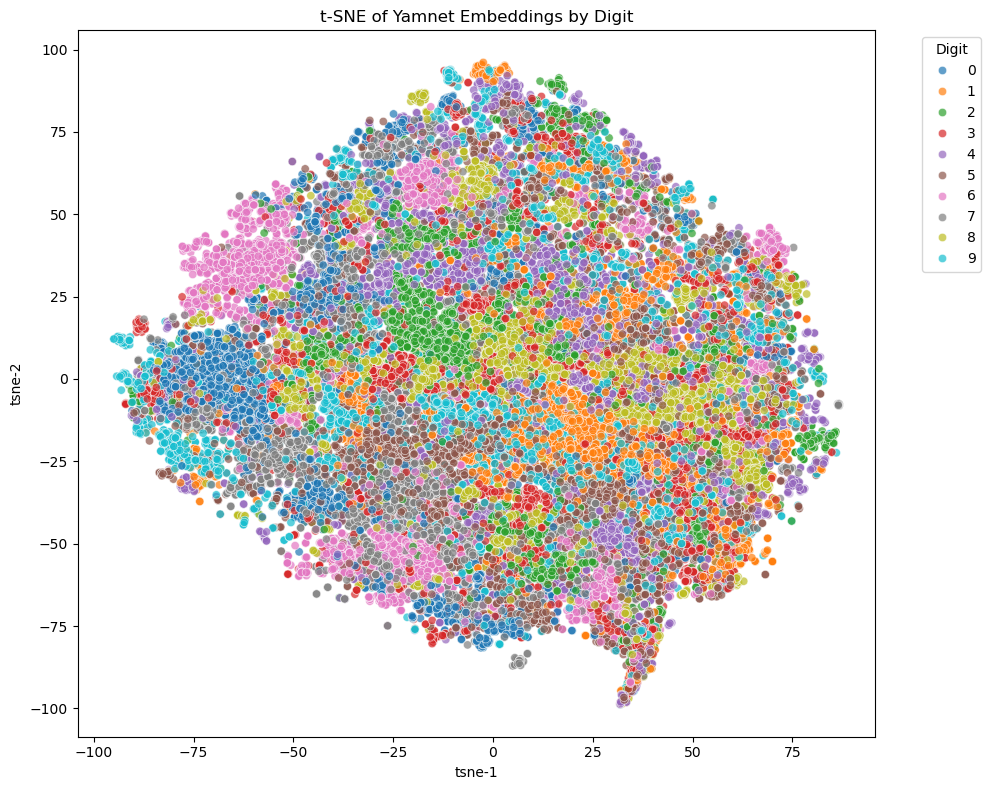

In [41]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="digit",
    palette=sns.color_palette("tab10", 10),
    data=df_tsne_yamnet,
    alpha=0.7
)
plt.title("t-SNE of Yamnet Embeddings by Digit")
plt.legend(title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The t-SNE plot shows that YAMNet embeddings do not separate the digits well. All the colors are mixed together, which explains why retrieval accuracy was poor. This suggests that YAMNet does not enough detail to distinguish between different spoken digits.

#### Wav2Vec

Wav2Vec is a deep learning model developed by Facebook AI that learns powerful representations directly from raw audio waveforms. Unlike traditional handcrafted features like MFCCs or models trained on broad audio categories like YAMNet, Wav2Vec is specifically designed for speech processing. It was pretrained on large amounts of unlabeled speech data and fine-tuned for automatic speech recognition tasks, which makes it particularly good at capturing the subtle acoustic patterns in human speech.

I used Wav2Vec because it is designed for speech and creates embeddings that are more robust to speaker and recording differences

In [9]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").eval()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
def extract_wav2vec_embedding(audio_path, sr=16000):
    waveform, original_sr = torchaudio.load(audio_path)
    if original_sr != sr:
        resampler = torchaudio.transforms.Resample(orig_freq=original_sr, new_freq=sr)
        waveform = resampler(waveform)

    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Normalize 
    input_values = processor(waveform.squeeze().numpy(), return_tensors="pt", sampling_rate=sr).input_values

    with torch.no_grad():
        outputs = model(input_values)

    embeddings = outputs.last_hidden_state

    # mean over time axis
    embedding = embeddings.mean(dim=1).squeeze().numpy().astype("float32")  # (768,)
    return embedding


Trying a little preprocessing for querry audio

In [132]:
embeddings = []
labels = []

In [57]:


for fname in tqdm(df_meta['path'][11711:30001]):
    if fname.endswith(".wav"):
        # path = os.path.join(audio_folder, fname)
        emb = extract_wav2vec_embedding(fname)
        embeddings.append(emb)
        

        # digit_label = fname[0]  # assuming '3_xxx.wav'
        # labels.append(int(digit_label))

X = np.array(embeddings)
# y = np.array(labels)


100%|████████████████████████████████████████████████████████████████████████████| 18289/18289 [59:27<00:00,  5.13it/s]


In [58]:
X = np.array(embeddings)

In [60]:
d = X.shape[1]
index = faiss.IndexFlatIP(d)  # cosine similarity
faiss.normalize_L2(X)
index.add(X)

# Save if needed
faiss.write_index(index, "wav2vec_faiss.index")
np.save("wav2vec_embeddings.npy", X)


In [23]:
X = np.load("wav2vec_embeddings.npy")
d = X.shape[1]
index = faiss.IndexFlatIP(d)  # cosine similarity
index = faiss.read_index("wav2vec_faiss.index")

In [115]:
# Evaluation loop
k = 10
precisions, avg_precisions, rranks = [], [], []

for i in tqdm(range(len(X))):
    query = X[i].reshape(1, -1)
    # true_digit = df_meta.iloc[i]["digit"]
    true_digit = str(df_meta.iloc[i]["digit"])


    # Retrieve top-k (excluding self-match)
    D, I = index.search(query, k + 1)
    # print(I.shape)
    indices = I[0]
    if len(indices) > 1:
        indices = indices[1:]  # exclude self-match
    retrieved_digits = df_meta.iloc[indices]["digit"].tolist()
    # retrieved_digits = df_meta.iloc[I[0][1:]]["digit"].tolist()

    # Evaluate
    precisions.append(precision_at_k(true_digit, retrieved_digits, k))
    avg_precisions.append(average_precision(true_digit, retrieved_digits))
    rranks.append(reciprocal_rank(true_digit, retrieved_digits))

# Summary
print(f"\n📊 Evaluation Summary:")
print(f"Mean Precision@{k}: {np.mean(precisions):.4f}")
print(f"Mean Average Precision (MAP): {np.mean(avg_precisions):.4f}")
print(f"Mean Reciprocal Rank (MRR): {np.mean(rranks):.4f}")

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [07:19<00:00, 68.21it/s]


📊 Evaluation Summary:
Mean Precision@10: 0.9932
Mean Average Precision (MAP): 0.9962
Mean Reciprocal Rank (MRR): 0.9977


In [24]:
true_labels = []
precisions = []
average_precisions = []
reciprocal_ranks = []
for filename in sorted(os.listdir(query_dir)):
    digit = str(os.path.splitext(filename)[0])  # assumes filename is the digit
    true_labels.append(digit)

    path = os.path.join(query_dir, filename)
    
    embedding = extract_wav2vec_embedding(path)

    faiss.normalize_L2(embedding.reshape(1, -1))
    D, I = index.search(embedding.reshape(1, -1), k)
    retrieved_digits = list(map(str, df_meta.iloc[I[0]]["digit"].tolist()))

    precisions.append(precision_at_k(digit, retrieved_digits, k))
    average_precisions.append(average_precision(digit, retrieved_digits))
    reciprocal_ranks.append(reciprocal_rank(digit, retrieved_digits))

    print(f"\n🎤 Query Digit: {digit}")
    print(f"🔍 Top-{k} Retrieved: {retrieved_digits}")

# ---- Summary ----
print("\n📊 Evaluation Summary:")
print(f"Mean Precision@{k}: {np.mean(precisions):.4f}")
print(f"Mean Average Precision (MAP): {np.mean(average_precisions):.4f}")
print(f"Mean Reciprocal Rank (MRR): {np.mean(reciprocal_ranks):.4f}")


🎤 Query Digit: 0
🔍 Top-10 Retrieved: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

🎤 Query Digit: 1
🔍 Top-10 Retrieved: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']

🎤 Query Digit: 2
🔍 Top-10 Retrieved: ['4', '4', '2', '1', '1', '1', '1', '1', '1', '1']

🎤 Query Digit: 3
🔍 Top-10 Retrieved: ['8', '8', '8', '8', '8', '8', '8', '8', '8', '8']

🎤 Query Digit: 4
🔍 Top-10 Retrieved: ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4']

🎤 Query Digit: 5
🔍 Top-10 Retrieved: ['5', '5', '5', '5', '5', '5', '5', '5', '5', '1']

🎤 Query Digit: 6
🔍 Top-10 Retrieved: ['6', '6', '6', '6', '6', '6', '6', '6', '6', '6']

🎤 Query Digit: 7
🔍 Top-10 Retrieved: ['7', '7', '7', '7', '7', '7', '7', '7', '7', '7']

🎤 Query Digit: 8
🔍 Top-10 Retrieved: ['8', '8', '8', '8', '8', '8', '8', '8', '8', '8']

🎤 Query Digit: 9
🔍 Top-10 Retrieved: ['5', '5', '5', '5', '0', '1', '1', '8', '8', '5']

📊 Evaluation Summary:
Mean Precision@10: 0.7000
Mean Average Precision (MAP): 0.7333
Mean Reciprocal Rank (MR

The results are better than YAMNet and MFCC vectors. Let's have a look at the 2D scatter plot of the Wav2Vec vectors

In [66]:

tsne_4 = TSNE(n_components=2, perplexity=30, random_state=42)
Wav2vec = tsne_4.fit_transform(X)


In [68]:
np.save("Wav2Vec_2d_tsne.npy", Wav2vec)   

In [69]:
df_tsne_Wav2Vec = pd.DataFrame()

df_tsne_Wav2Vec['tsne-1'] = Wav2vec[:, 0]
df_tsne_Wav2Vec['tsne-2'] = Wav2vec[:, 1]
df_tsne_Wav2Vec['digit'] = df_meta['digit']

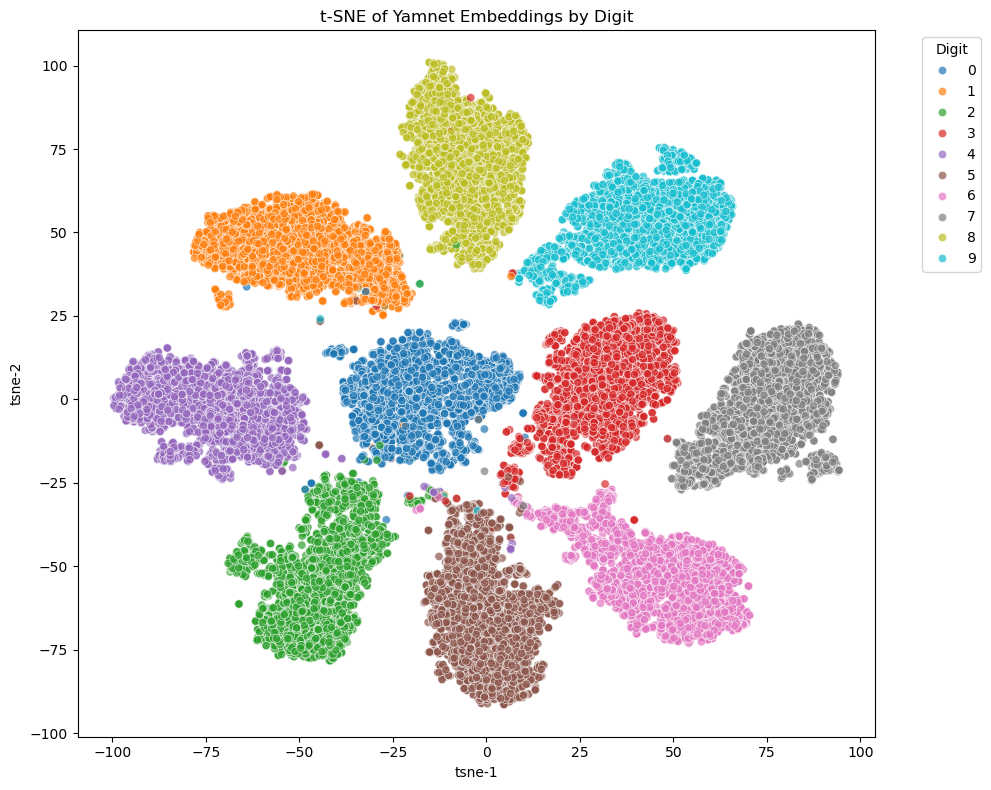

In [70]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="digit",
    palette=sns.color_palette("tab10", 10),
    data=df_tsne_Wav2Vec,
    alpha=0.7
)
plt.title("t-SNE of Yamnet Embeddings by Digit")
plt.legend(title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This t-SNE projection shows that Wav2Vec embeddings produce well-separated clusters for each spoken digit. Unlike the earlier MFCC and YAMNet plots, where different digits were heavily intermixed, here each color forms a distinct, dense group.

Let's visualise both querry and dataset side by side to understand the misclassification of the querry samples

In [71]:
query_embeddings = []
query_labels = []

for fname in sorted(os.listdir(query_dir)):
    if fname.endswith(".wav"):
        digit = int(fname.split(".")[0])  # filename: "0.wav", "1.wav" ...
        y, sr = torchaudio.load(os.path.join(query_dir, fname))
        emb = extract_wav2vec_embedding(os.path.join(query_dir, fname))
        query_embeddings.append(emb)
        query_labels.append(digit)

X_query = np.array(query_embeddings)
y_query = np.array(query_labels)

In [74]:
X_all = np.vstack([X, X_query])              # shape: (N + 10, 768)
y_all = np.concatenate([df_meta['digit'], y_query])
domain_labels = np.array(['Dataset'] * len(X) + ['Query'] * len(X_query))


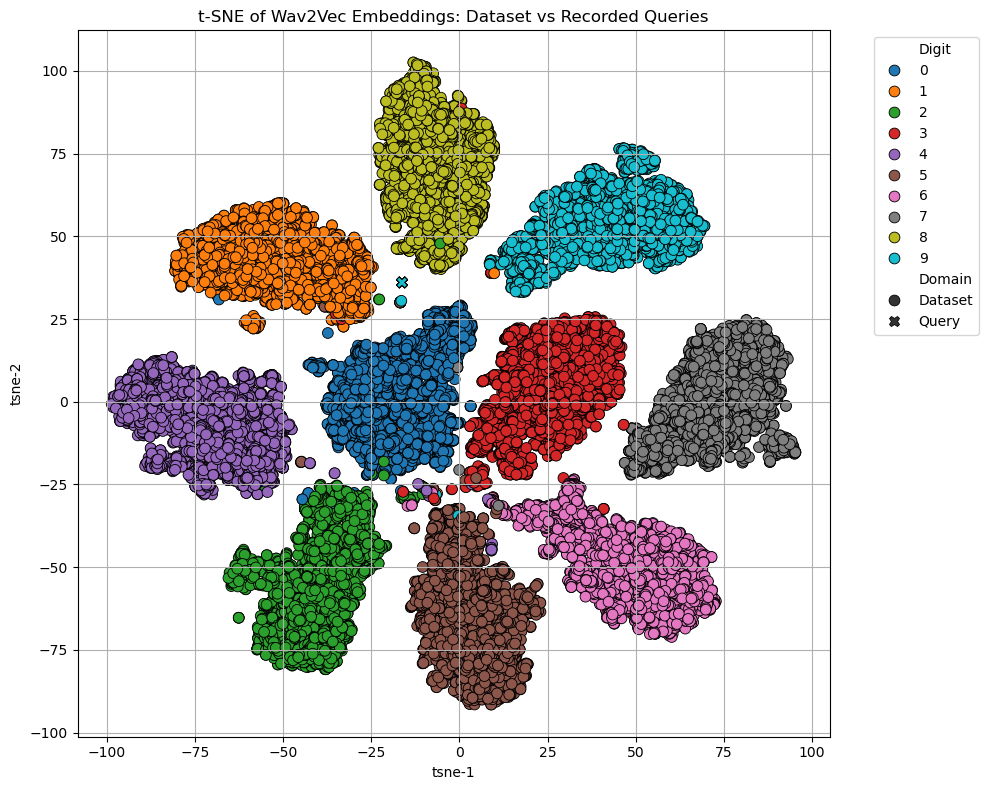

In [75]:
# Reduce to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_all)

# Prepare DataFrame for seaborn
df_vis = pd.DataFrame(X_2d, columns=["tsne-1", "tsne-2"])
df_vis["Digit"] = y_all
df_vis["Domain"] = domain_labels

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_vis, x="tsne-1", y="tsne-2", hue="Digit", style="Domain", s=60, palette="tab10", edgecolor="k")
plt.title("t-SNE of Wav2Vec Embeddings: Dataset vs Recorded Queries")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Not clear in this plot let's try another way

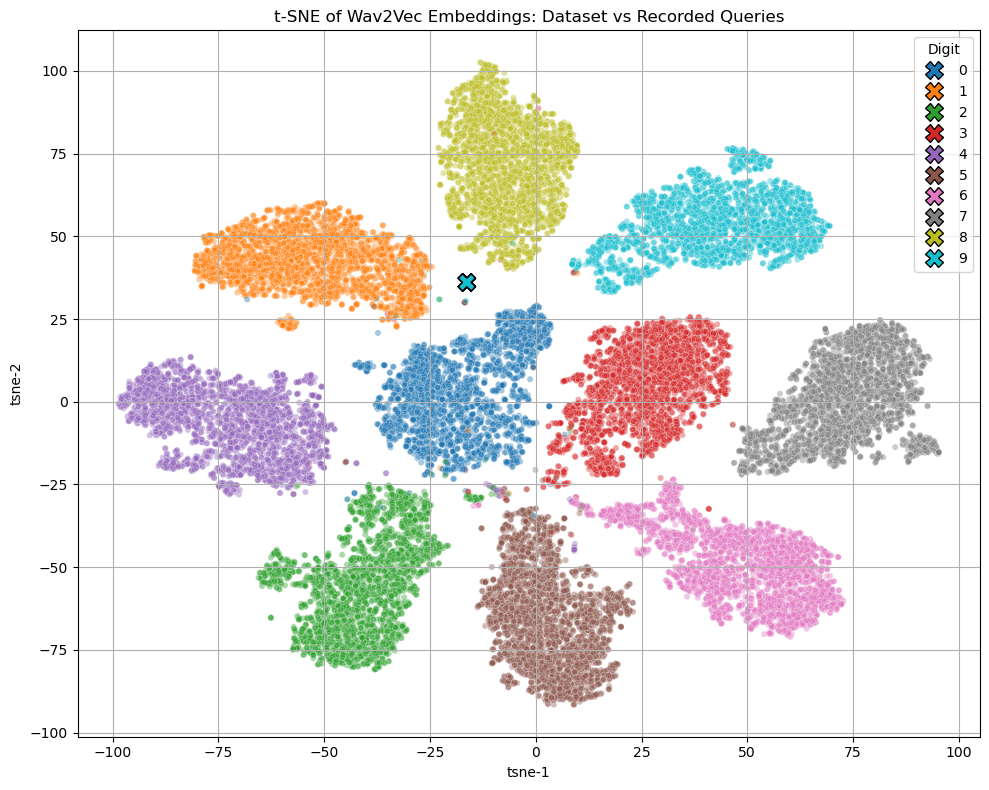

In [79]:
df_vis = pd.DataFrame(X_2d, columns=["tsne-1", "tsne-2"])
df_vis["Digit"] = y_all
df_vis["Domain"] = domain_labels

df_data = df_vis[df_vis["Domain"] == "Dataset"]
df_query = df_vis[df_vis["Domain"] == "Query"]

# Plot
plt.figure(figsize=(10, 8))

# Plot dataset points first (faded, smaller)
sns.scatterplot(
    data=df_data,
    x="tsne-1", y="tsne-2",
    hue="Digit",
    palette="tab10",
    alpha=0.4,
    s=20,
    legend=False
)

# Overlay query points (larger, darker edge, distinct marker)
sns.scatterplot(
    data=df_query,
    x="tsne-1", y="tsne-2",
    hue="Digit",
    palette="tab10",
    edgecolor="black",
    s=150,
    marker="X",
    legend="brief"
)

plt.title("t-SNE of Wav2Vec Embeddings: Dataset vs Recorded Queries")
plt.grid(True)
plt.tight_layout()
plt.show()

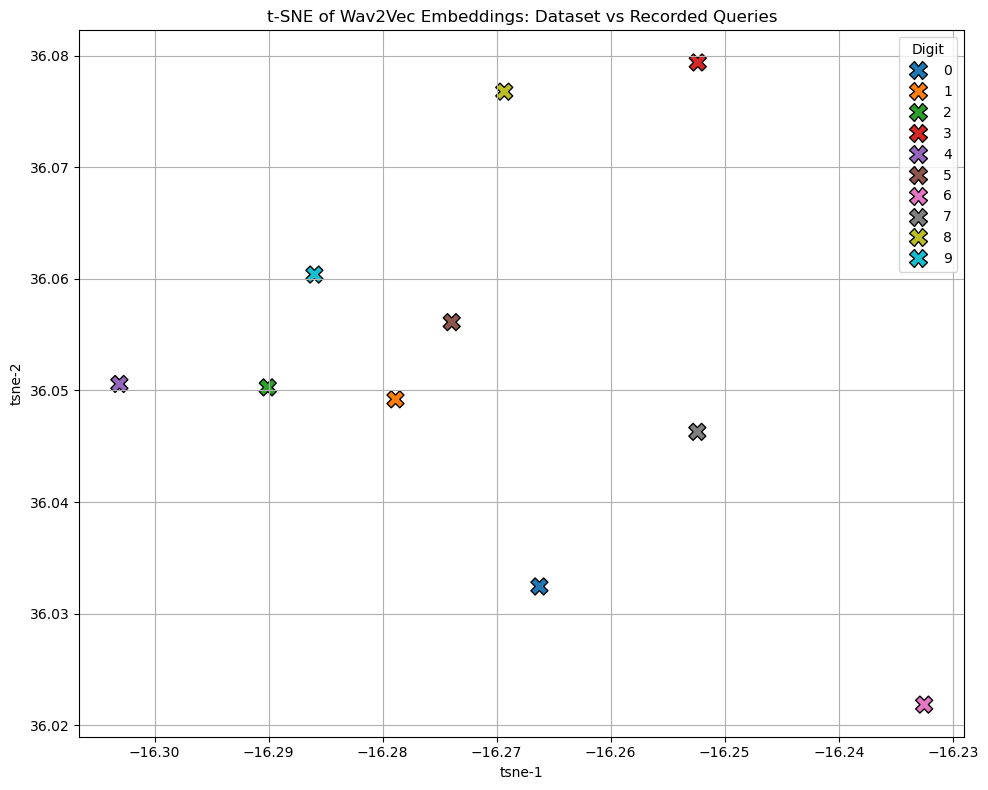

In [80]:
# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_query,
    x="tsne-1", y="tsne-2",
    hue="Digit",
    palette="tab10",
    edgecolor="black",
    s=150,
    marker="X",
    legend="brief"
)

plt.title("t-SNE of Wav2Vec Embeddings: Dataset vs Recorded Queries")
plt.grid(True)
plt.tight_layout()
plt.show()

This IR works better than the MFCC and yamnet
We can try to improve the precision if the user querry by performing some Preprocessing to audio clips the preprocessing can be little studied through 

Use different notebook for more readeability
Once the accuracy is acceptable then Try to incorporate the textual(multimodal retreuival)

In [25]:
results = []

for filename in sorted(os.listdir(query_dir)):
    digit = str(os.path.splitext(filename)[0])
    path = os.path.join(query_dir, filename)
    embedding = extract_wav2vec_embedding(path)

    faiss.normalize_L2(embedding.reshape(1, -1))
    D, I = index.search(embedding.reshape(1, -1), k)

    # Collect detailed metadata
    topk_df = df_meta.iloc[I[0]].copy()
    topk_df["score"] = D[0]
    topk_df["query_digit"] = digit

    results.append(topk_df)

# Combine all results into a single DataFrame
df_all_results = pd.concat(results, ignore_index=True)

# Save to CSV for inspection
df_all_results.to_csv("wav2vec_query_retrievals.csv", index=False)


In [29]:
# df_all_results = pd.read_csv("wav2vec_query_retrievals.csv")

confusion = pd.crosstab(df_all_results["query_digit"], df_all_results["digit"])
# print(confusion)

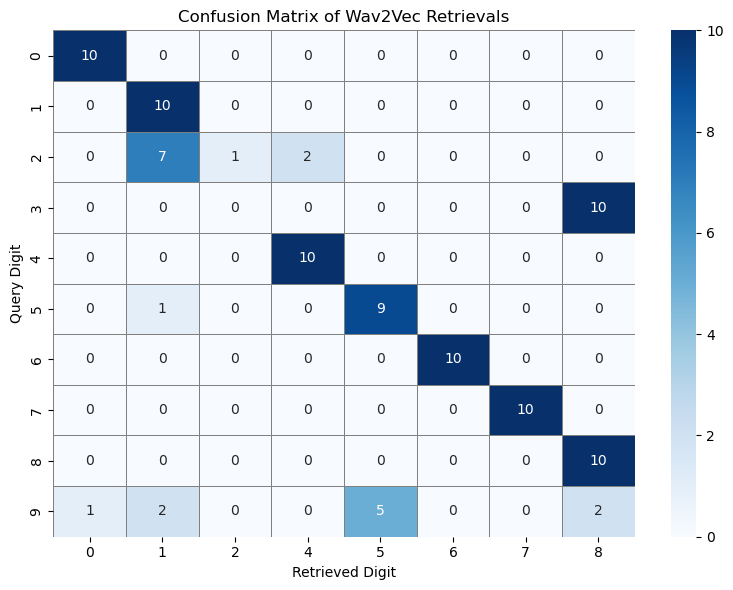

In [30]:
plt.figure(figsize=(8,6))
sns.heatmap(
    confusion,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
    linewidths=0.5,
    linecolor="gray"
)

plt.xlabel("Retrieved Digit")
plt.ylabel("Query Digit")
plt.title("Confusion Matrix of Wav2Vec Retrievals")
plt.tight_layout()
plt.show()

In [41]:
df_meta

accent  gender age                                               path  \
0      german    male  30  C:\Users\shri\Data_Science\Image_generation\au...   
1      german    male  30  C:\Users\shri\Data_Science\Image_generation\au...   
2      german    male  30  C:\Users\shri\Data_Science\Image_generation\au...   
3      german    male  30  C:\Users\shri\Data_Science\Image_generation\au...   
4      german    male  30  C:\Users\shri\Data_Science\Image_generation\au...   
...       ...     ...  ..                                                ...   
29995   Tamil  female  27  C:\Users\shri\Data_Science\Image_generation\au...   
29996   Tamil  female  27  C:\Users\shri\Data_Science\Image_generation\au...   
29997   Tamil  female  27  C:\Users\shri\Data_Science\Image_generation\au...   
29998   Tamil  female  27  C:\Users\shri\Data_Science\Image_generation\au...   
29999   Tamil  female  27  C:\Users\shri\Data_Science\Image_generation\au...   

      digit  
0         0  
1         0  
2         0  
3         0  
4         0  
...     ...  
29995     9  
29996     9  
29997     9  
29998     9  
29999     9  

[30000 rows x 5 columns]

In [43]:
def rms_normalize(y, target_db=-20.0):
    rms = np.sqrt(np.mean(y**2))
    scalar = 10**(target_db/20) / (rms + 1e-8)
    return y * scalar

# # --------------------------
# # Load Wav2Vec2
# # --------------------------
# processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
# model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").eval()

# --------------------------
# Paths
# --------------------------
# audio_folder = "path_to_your_audio_collection"
output_embeddings = "wav2vec_embeddings_rmsnorm.npy"
faiss_index_path = "wav2vec_faiss_rmsnorm.index"

# --------------------------
# Collect all WAV files
# --------------------------
# wav_files = [os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith(".wav")]
# print(f"Found {len(wav_files)} audio files.")

# --------------------------
# Process and embed
# --------------------------
embeddings3 = []

for path in tqdm(df_meta['path']):
    # Load
    y, sr = librosa.load(path, sr=16000)
    # Trim silence
    y, _ = librosa.effects.trim(y, top_db=30)
    # RMS normalize
    y = rms_normalize(y, target_db=-20.0)
    # Convert to tensor
    waveform = torch.tensor(y).unsqueeze(0)

    # Prepare input
    input_values = processor(
        waveform.squeeze().numpy(),
        return_tensors="pt",
        sampling_rate=16000
    ).input_values

    # Forward
    with torch.no_grad():
        outputs = model(input_values)

    emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    emb /= np.linalg.norm(emb)

    embeddings3.append(emb)

# Stack
X3 = np.vstack(embeddings3)
print("Embedding matrix shape:", X3.shape)

# Save embeddings
np.save(output_embeddings, X3)
print("Saved embeddings:", output_embeddings)

# Build FAISS index
d3 = X3.shape[1]
index3 = faiss.IndexFlatIP(d3)  # Cosine similarity if normalized
index3.add(X)

faiss.write_index(index3, faiss_index_path)
print("Saved FAISS index:", faiss_index_path)


100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [2:08:59<00:00,  3.88it/s]


Embedding matrix shape: (30000, 768)
Saved embeddings: wav2vec_embeddings_rmsnorm.npy
Saved FAISS index: wav2vec_faiss_rmsnorm.index


In [44]:
true_labels = []
precisions = []
average_precisions = []
reciprocal_ranks = []
for filename in sorted(os.listdir(query_dir)):
    digit = str(os.path.splitext(filename)[0])  # assumes filename is the digit
    true_labels.append(digit)

    path = os.path.join(query_dir, filename)
    
    embedding = extract_wav2vec_embedding(path)

    faiss.normalize_L2(embedding.reshape(1, -1))
    D, I = index3.search(embedding.reshape(1, -1), k)
    retrieved_digits = list(map(str, df_meta.iloc[I[0]]["digit"].tolist()))

    precisions.append(precision_at_k(digit, retrieved_digits, k))
    average_precisions.append(average_precision(digit, retrieved_digits))
    reciprocal_ranks.append(reciprocal_rank(digit, retrieved_digits))

    print(f"\n🎤 Query Digit: {digit}")
    print(f"🔍 Top-{k} Retrieved: {retrieved_digits}")

# ---- Summary ----
print("\n📊 Evaluation Summary:")
print(f"Mean Precision@{k}: {np.mean(precisions):.4f}")
print(f"Mean Average Precision (MAP): {np.mean(average_precisions):.4f}")
print(f"Mean Reciprocal Rank (MRR): {np.mean(reciprocal_ranks):.4f}")


🎤 Query Digit: 0
🔍 Top-10 Retrieved: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

🎤 Query Digit: 1
🔍 Top-10 Retrieved: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']

🎤 Query Digit: 2
🔍 Top-10 Retrieved: ['4', '4', '2', '1', '1', '1', '1', '1', '1', '1']

🎤 Query Digit: 3
🔍 Top-10 Retrieved: ['8', '8', '8', '8', '8', '8', '8', '8', '8', '8']

🎤 Query Digit: 4
🔍 Top-10 Retrieved: ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4']

🎤 Query Digit: 5
🔍 Top-10 Retrieved: ['5', '5', '5', '5', '5', '5', '5', '5', '5', '1']

🎤 Query Digit: 6
🔍 Top-10 Retrieved: ['6', '6', '6', '6', '6', '6', '6', '6', '6', '6']

🎤 Query Digit: 7
🔍 Top-10 Retrieved: ['7', '7', '7', '7', '7', '7', '7', '7', '7', '7']

🎤 Query Digit: 8
🔍 Top-10 Retrieved: ['8', '8', '8', '8', '8', '8', '8', '8', '8', '8']

🎤 Query Digit: 9
🔍 Top-10 Retrieved: ['5', '5', '5', '5', '0', '1', '1', '8', '8', '5']

📊 Evaluation Summary:
Mean Precision@10: 0.7000
Mean Average Precision (MAP): 0.7333
Mean Reciprocal Rank (MR

### Conclusion

 Despite exploring a wide range of methods and optimizations in this project—including MFCC features, YAMNet embeddings, and several retrieval and indexing strategies—overall performance improvements remained limited, especially on externally recorded queries. Among all approaches, Wav2Vec embeddings consistently achieved the best retrieval performance, significantly outperforming traditional features. However, even with Wav2Vec, the results did not fully meet the desired expectations for real-world robustness. Given the extensive efforts invested and the diminishing returns of further experimentation, this project is now concluded. The work nonetheless provided valuable experience and insights into the challenges of audio-based and cross-modal information retrieval.